In [1]:
import matplotlib.pyplot as plt
from yadlt.context import FitContext

import logging
from yadlt.log import setup_logger

# Set up the root logger to capture all logs in jupyter notebook
logger = setup_logger()

# If you want to see all messages, including DEBUG:
logger.setLevel(logging.INFO)

In [66]:
from yadlt.plotting.plotting import produce_plot, LABELSIZE, LEGENDSIZE, TICKSIZE, FONTSIZE
from yadlt.utils import compute_delta_ntk

import numpy as np
from pathlib import Path

FIGRATIO = np.array((5, 3))
THIS = Path.cwd().parent / "doc/figs"

# Set consistent style
plt.rcParams.update({
    'font.size': FONTSIZE,
    'axes.labelsize': LABELSIZE,
    'xtick.labelsize': TICKSIZE,
    'ytick.labelsize': TICKSIZE,
    'legend.fontsize': LEGENDSIZE,
    'figure.dpi': 300,
})

In [5]:
context_L0 = FitContext("250911-04-L0-nnpdf-like")
context_L1 = FitContext("250911-05-L1-nnpdf-like")
context_L2 = FitContext("250911-06-L2-nnpdf-like")

# Eigenvalues

In [45]:
from doc.scripts.ntk_initialisation import SERIALIZATION_FOLDER
import pickle

ARCHITECTURES = [
    [10, 10],
    [25, 20],
    [100, 100],
    [1000, 1000],
    # [2000, 2000],
    # [10000, 10000],
]

group_dict = {}
for arch in ARCHITECTURES:
  ntk_by_reps = pickle.load(open(SERIALIZATION_FOLDER / f"ntk_initialization_{arch[0]}.pkl", "rb"))
  eigvals_by_reps = pickle.load(open(SERIALIZATION_FOLDER / f"eigvals_initialization_{arch[0]}.pkl", "rb"))
  frob_norm_by_reps = pickle.load(open(SERIALIZATION_FOLDER / f"frob_norm_initialization_{arch[0]}.pkl","rb",))

  group_dict[tuple(arch)] = {
    "ntk": ntk_by_reps,
    "eigvals": eigvals_by_reps,
    "frob_norm": frob_norm_by_reps,
  }

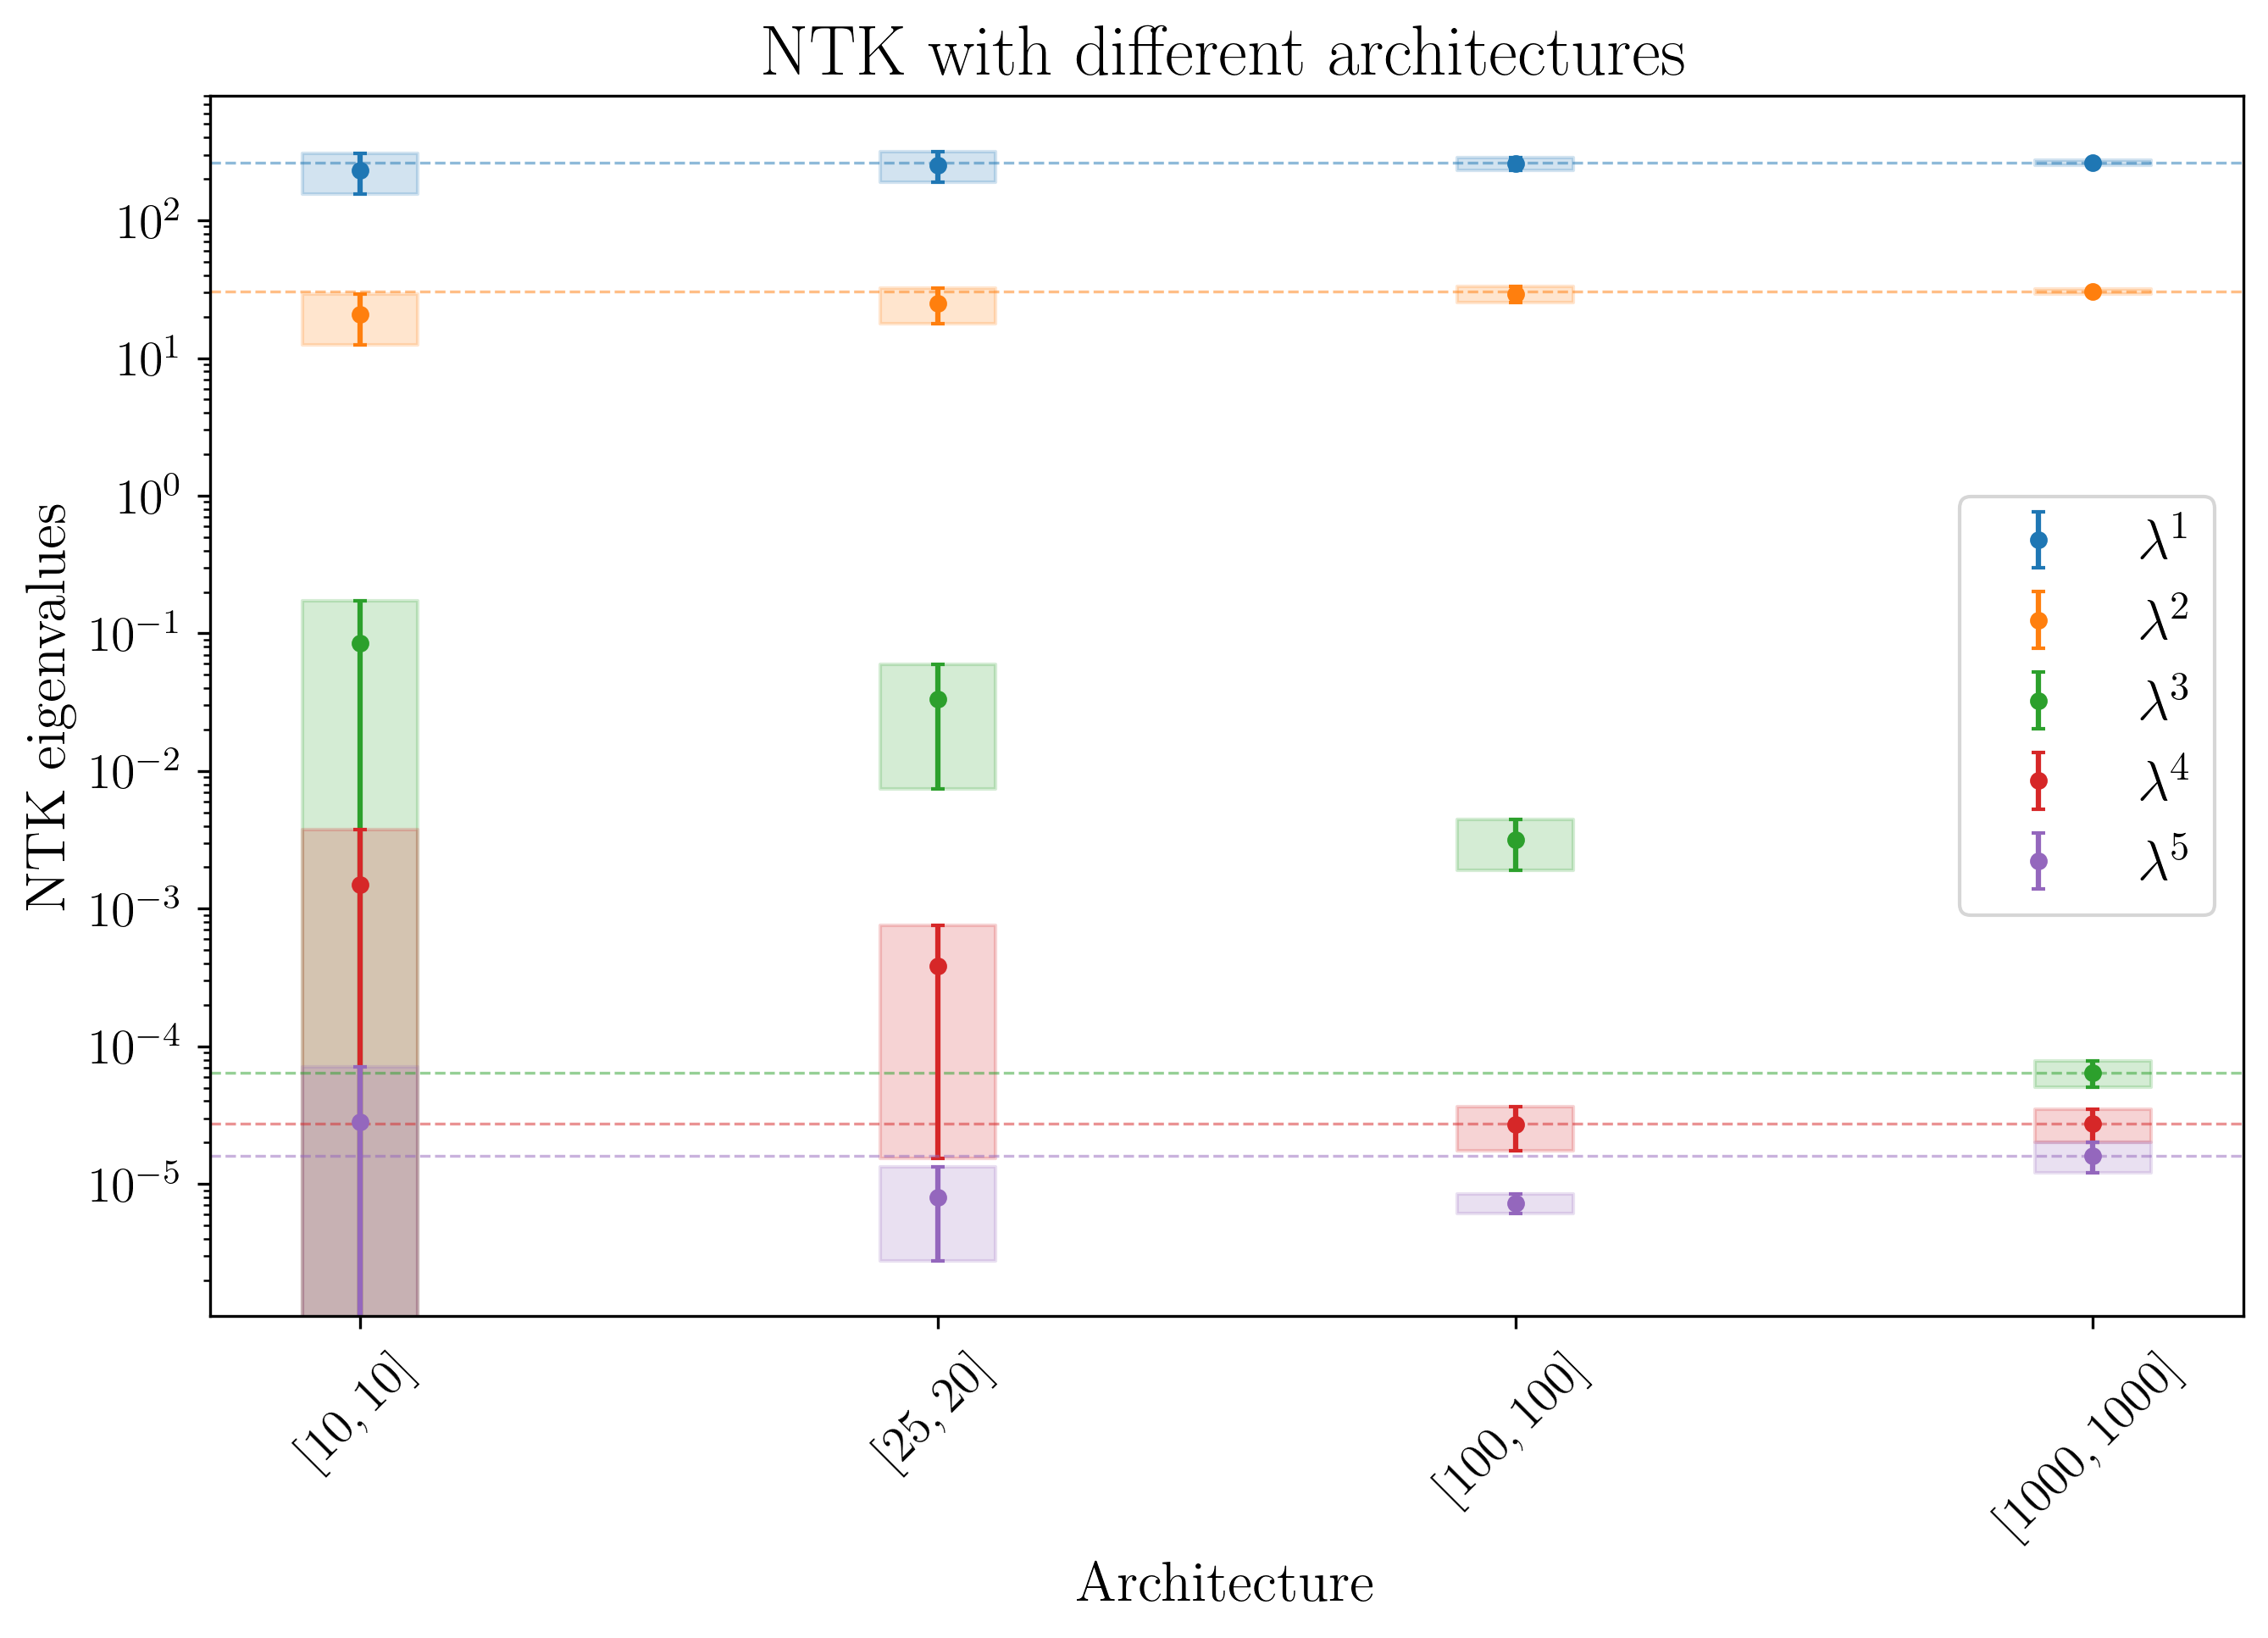

In [67]:
fig = plt.figure(figsize=FIGRATIO*2)
ax = fig.add_subplot(111)
plt.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.95)

# fig, ax = plt.subplots(1, 1, figsize=FIGRATIO*6, constrained_layout=True)

# X-axis labels for architectures
x_labels_ax1 = [rf"$[{a[0]},{a[1]}]$" for a in ARCHITECTURES]
x_positions_ax1 = np.arange(len(ARCHITECTURES))

# Compute and plot eigenvalues for each architecture
mean_eigvals_by_arch = []
std_eigvals_by_arch = []
for arch in group_dict.values():
    eigvals = arch["eigvals"]
    tmp_mean = [mean for mean in eigvals.get_mean()[:5]]
    tmp_std = [std for std in eigvals.get_std()[:5]]
    mean_eigvals_by_arch.append(tmp_mean)
    std_eigvals_by_arch.append(tmp_std)

mean_eigvals_by_arch = np.array(mean_eigvals_by_arch)  # [arch, eigvals]
std_eigvals_by_arch = np.array(std_eigvals_by_arch)  # [arch, eigvals]

# Store handles for legend
handles = []
labels = []

for idx in range(mean_eigvals_by_arch.shape[1]):
    means = mean_eigvals_by_arch[:, idx]
    stds = std_eigvals_by_arch[:, idx]

    # Plot the eigenvalues with error bars
    line = ax.errorbar(
        x_positions_ax1,
        means,
        yerr=stds,
        fmt="o",
        capsize=2,
        markersize=4,
        label=rf"$\lambda^{{{idx + 1}}}$",
        color=f"C{idx}",
    )

    # Plot horizontal line for last architecture
    ax.axhline(
        y=mean_eigvals_by_arch[-1, idx],
        color=line[0].get_color(),
        linestyle="--",
        linewidth=0.8,
        alpha=0.5,
    )

    handles.append(line)
    labels.append(rf"$\lambda^{{{idx + 1}}}$")

    for i, (m, s) in enumerate(zip(means, stds)):
        ax.fill_between(
            [i - 0.1, i + 0.1],
            [m - s, m - s],
            [m + s, m + s],
            alpha=0.2,
            color=f"C{idx}",
        )

    ax.set_xlabel(r"${\rm Architecture}$")
    ax.set_ylabel(r"$\textrm{NTK eigenvalues}$", fontsize=LABELSIZE)
    ax.set_title(r"$\textrm{NTK with different architectures}$", fontsize=FONTSIZE)
    ax.set_xticks(x_positions_ax1)
    ax.set_xticklabels(x_labels_ax1, rotation=45, fontsize=TICKSIZE)
    ax.set_yscale("log")

ax.legend(handles, labels, fontsize=LEGENDSIZE)
fig.savefig(THIS / "section_3/ntk_initialization_arch.pdf", bbox_inches="tight")

# $\delta \Theta$

In [ ]:
DELTA_NTK_DATA_DICT = {
    "fitnames": [
        "250911-04-L0-nnpdf-like",
        "250911-05-L1-nnpdf-like",
        "250911-06-L2-nnpdf-like",
    ],
    "fitlabels": ["$\\textrm{L0}$", "$\\textrm{L1}$", "$\\textrm{L2}$"],
    "fitcolors": ["C0", "C1", "C2"],
    "filename": "delta_ntk.pdf",
}

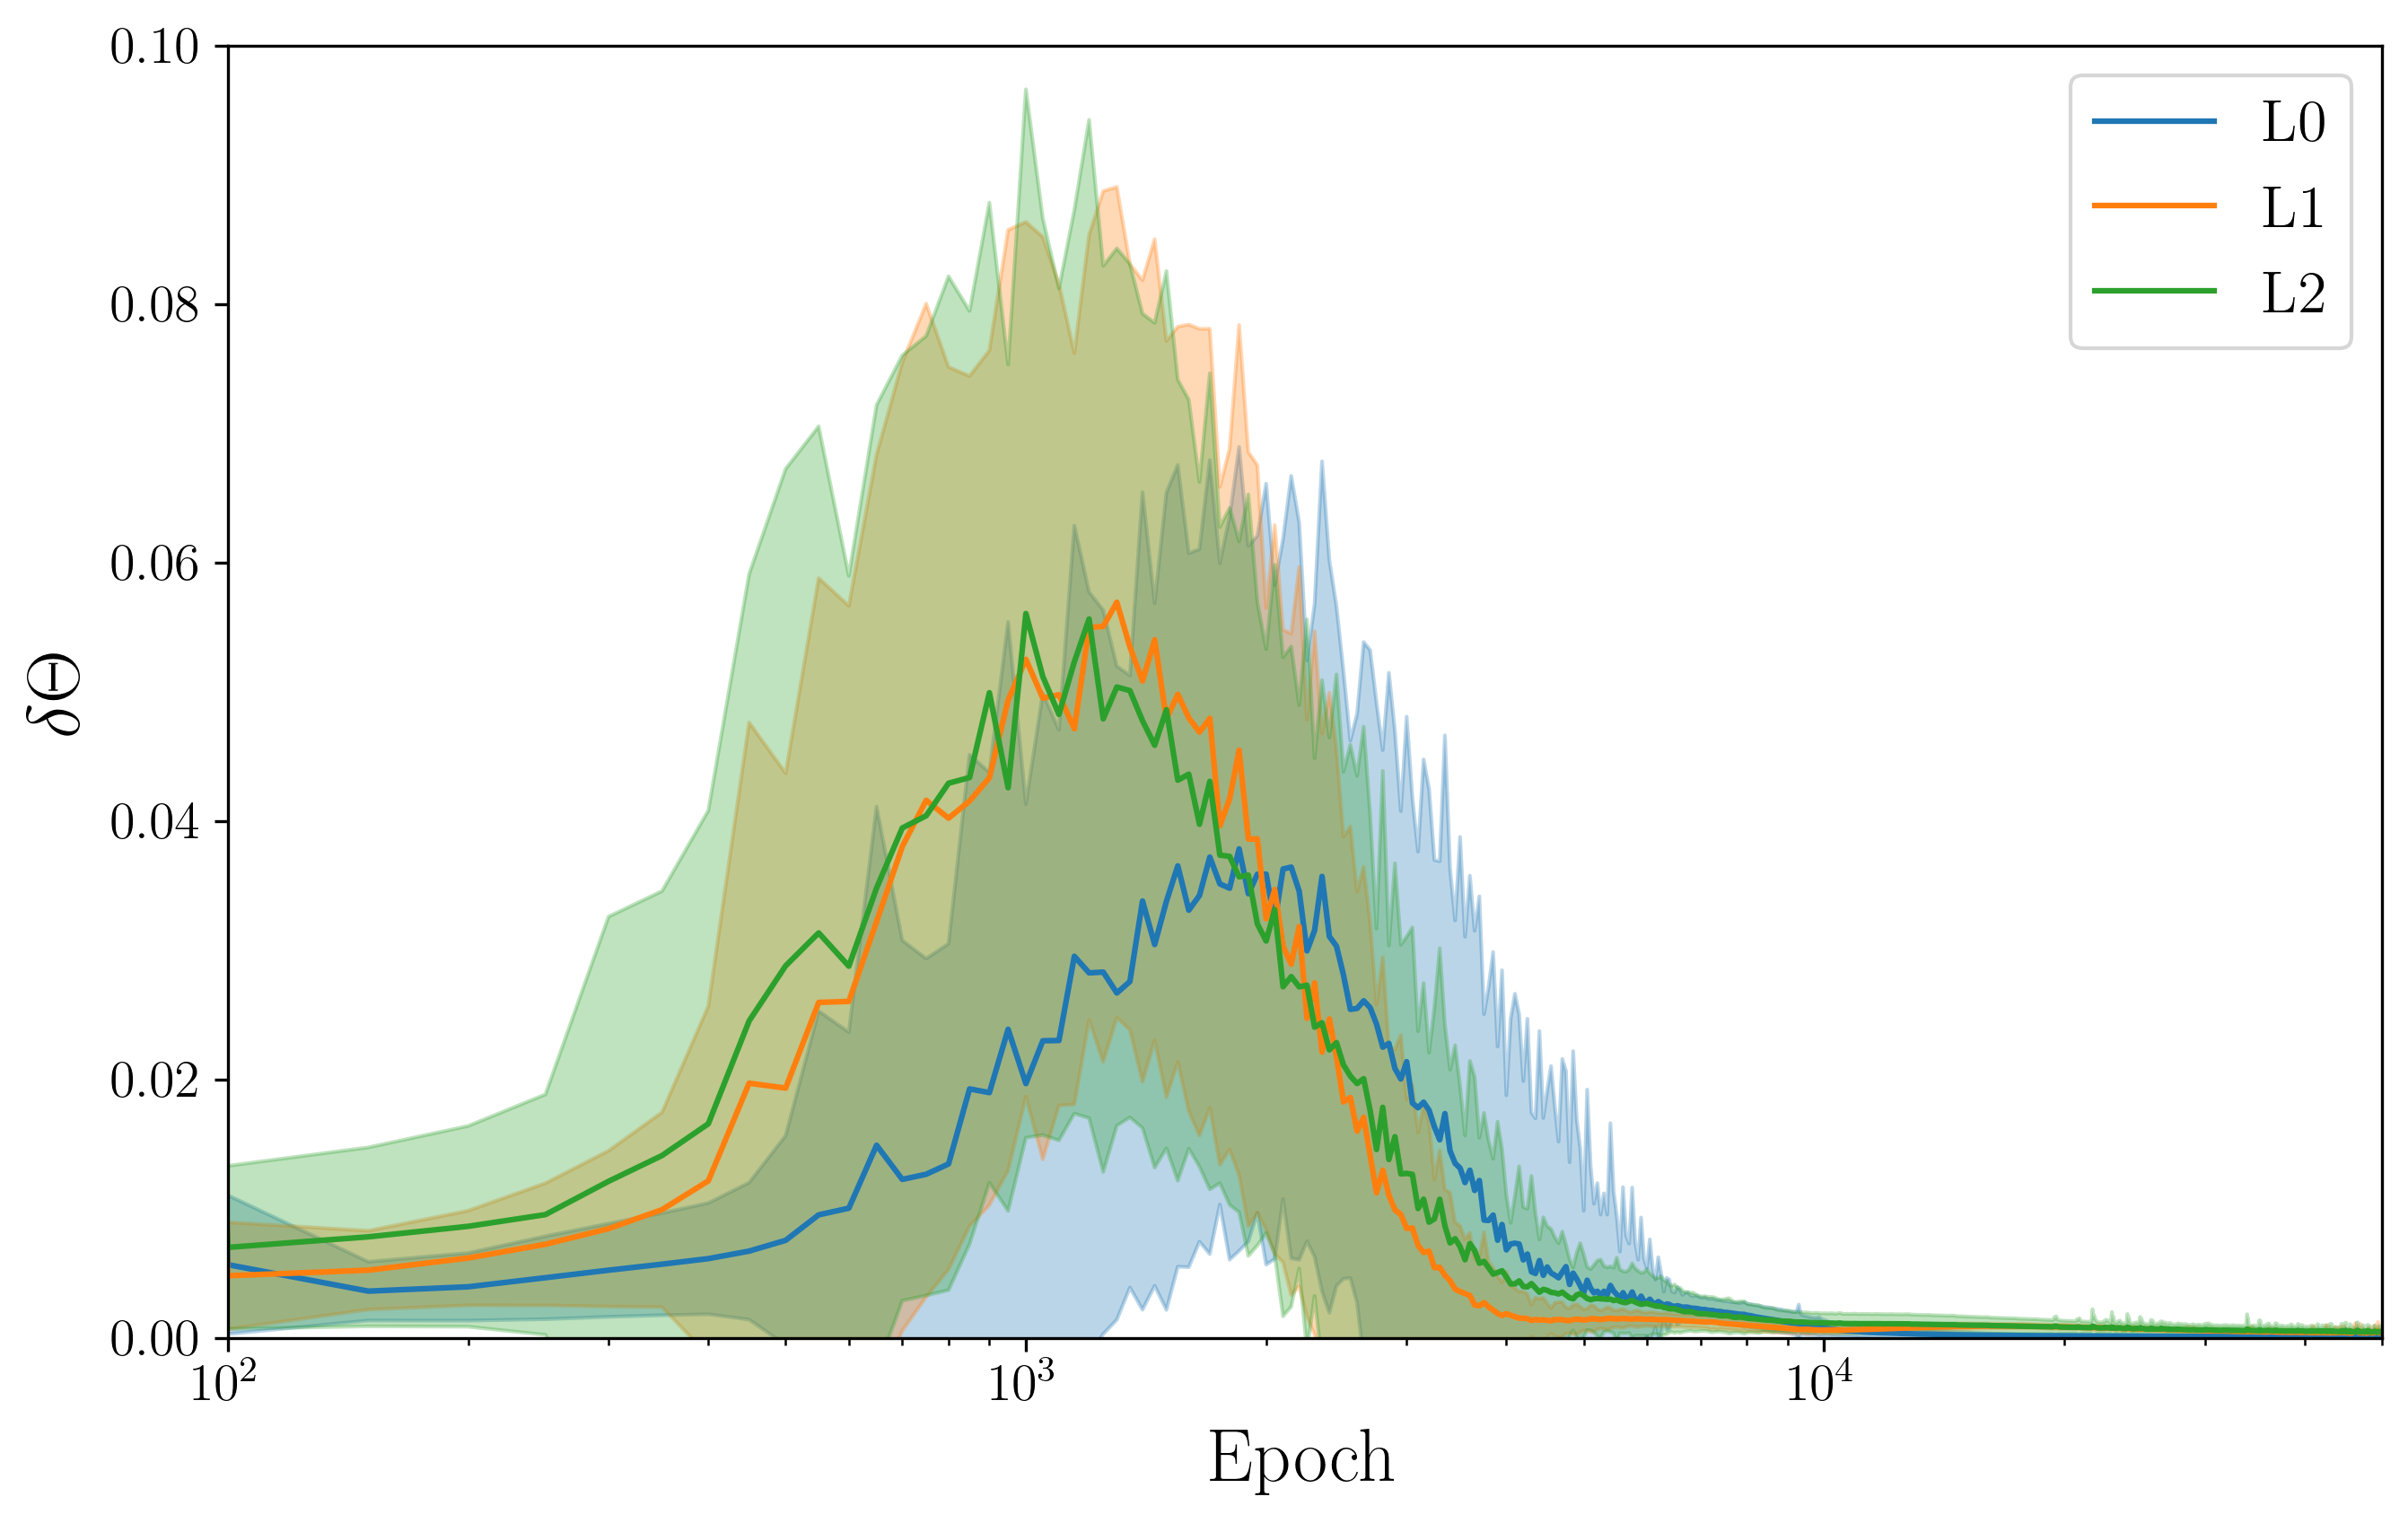

In [ ]:
fitlabels = ["$\\textrm{L0}$", "$\\textrm{L1}$", "$\\textrm{L2}$"]
fitcolors = ["C0", "C1", "C2"]
dist_grids = []
epochs = context_L0.get_config("replicas", "common_epochs")
for idx, ctx  in enumerate([context_L0, context_L1, context_L2]):
    context = ctx
    data_type = context.get_config("metadata", "arguments")["data"]
    delta_ntk_distribution_by_epoch = compute_delta_ntk(context)
    assert np.array_equal(epochs, context.get_config("replicas", "common_epochs")), "Epochs do not match across fits."
    dist_grids.append(delta_ntk_distribution_by_epoch)


fig = plt.figure(figsize=FIGRATIO*2)
ax = fig.add_subplot(111)
plt.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.95)

produce_plot(
  epochs[1::],
  dist_grids,
  xlabel=r"${\rm Epoch}$",
  ylabel=r"$\delta \Theta$",
  labels=fitlabels,
  colors=fitcolors,
  ax=ax
)

ax.set_xscale("log")
ax.set_ylim(0., 0.1)
ax.set_xlim(1e2, 5e4)
fig.savefig(THIS / "section_3/delta_ntk.pdf", bbox_inches="tight")

In [122]:
ctx_L0_large = FitContext("250713-05-L0-large")
ctx_L1_large = FitContext("250713-06-L1-large")
ctx_L2_large = FitContext("250713-07-L2-large")

ctx_L0_old = FitContext("250713-01-L0-nnpdf-like")
ctx_L1_old = FitContext("250713-02-L1-nnpdf-like")
ctx_L2_old = FitContext("250713-03-L2-nnpdf-like")

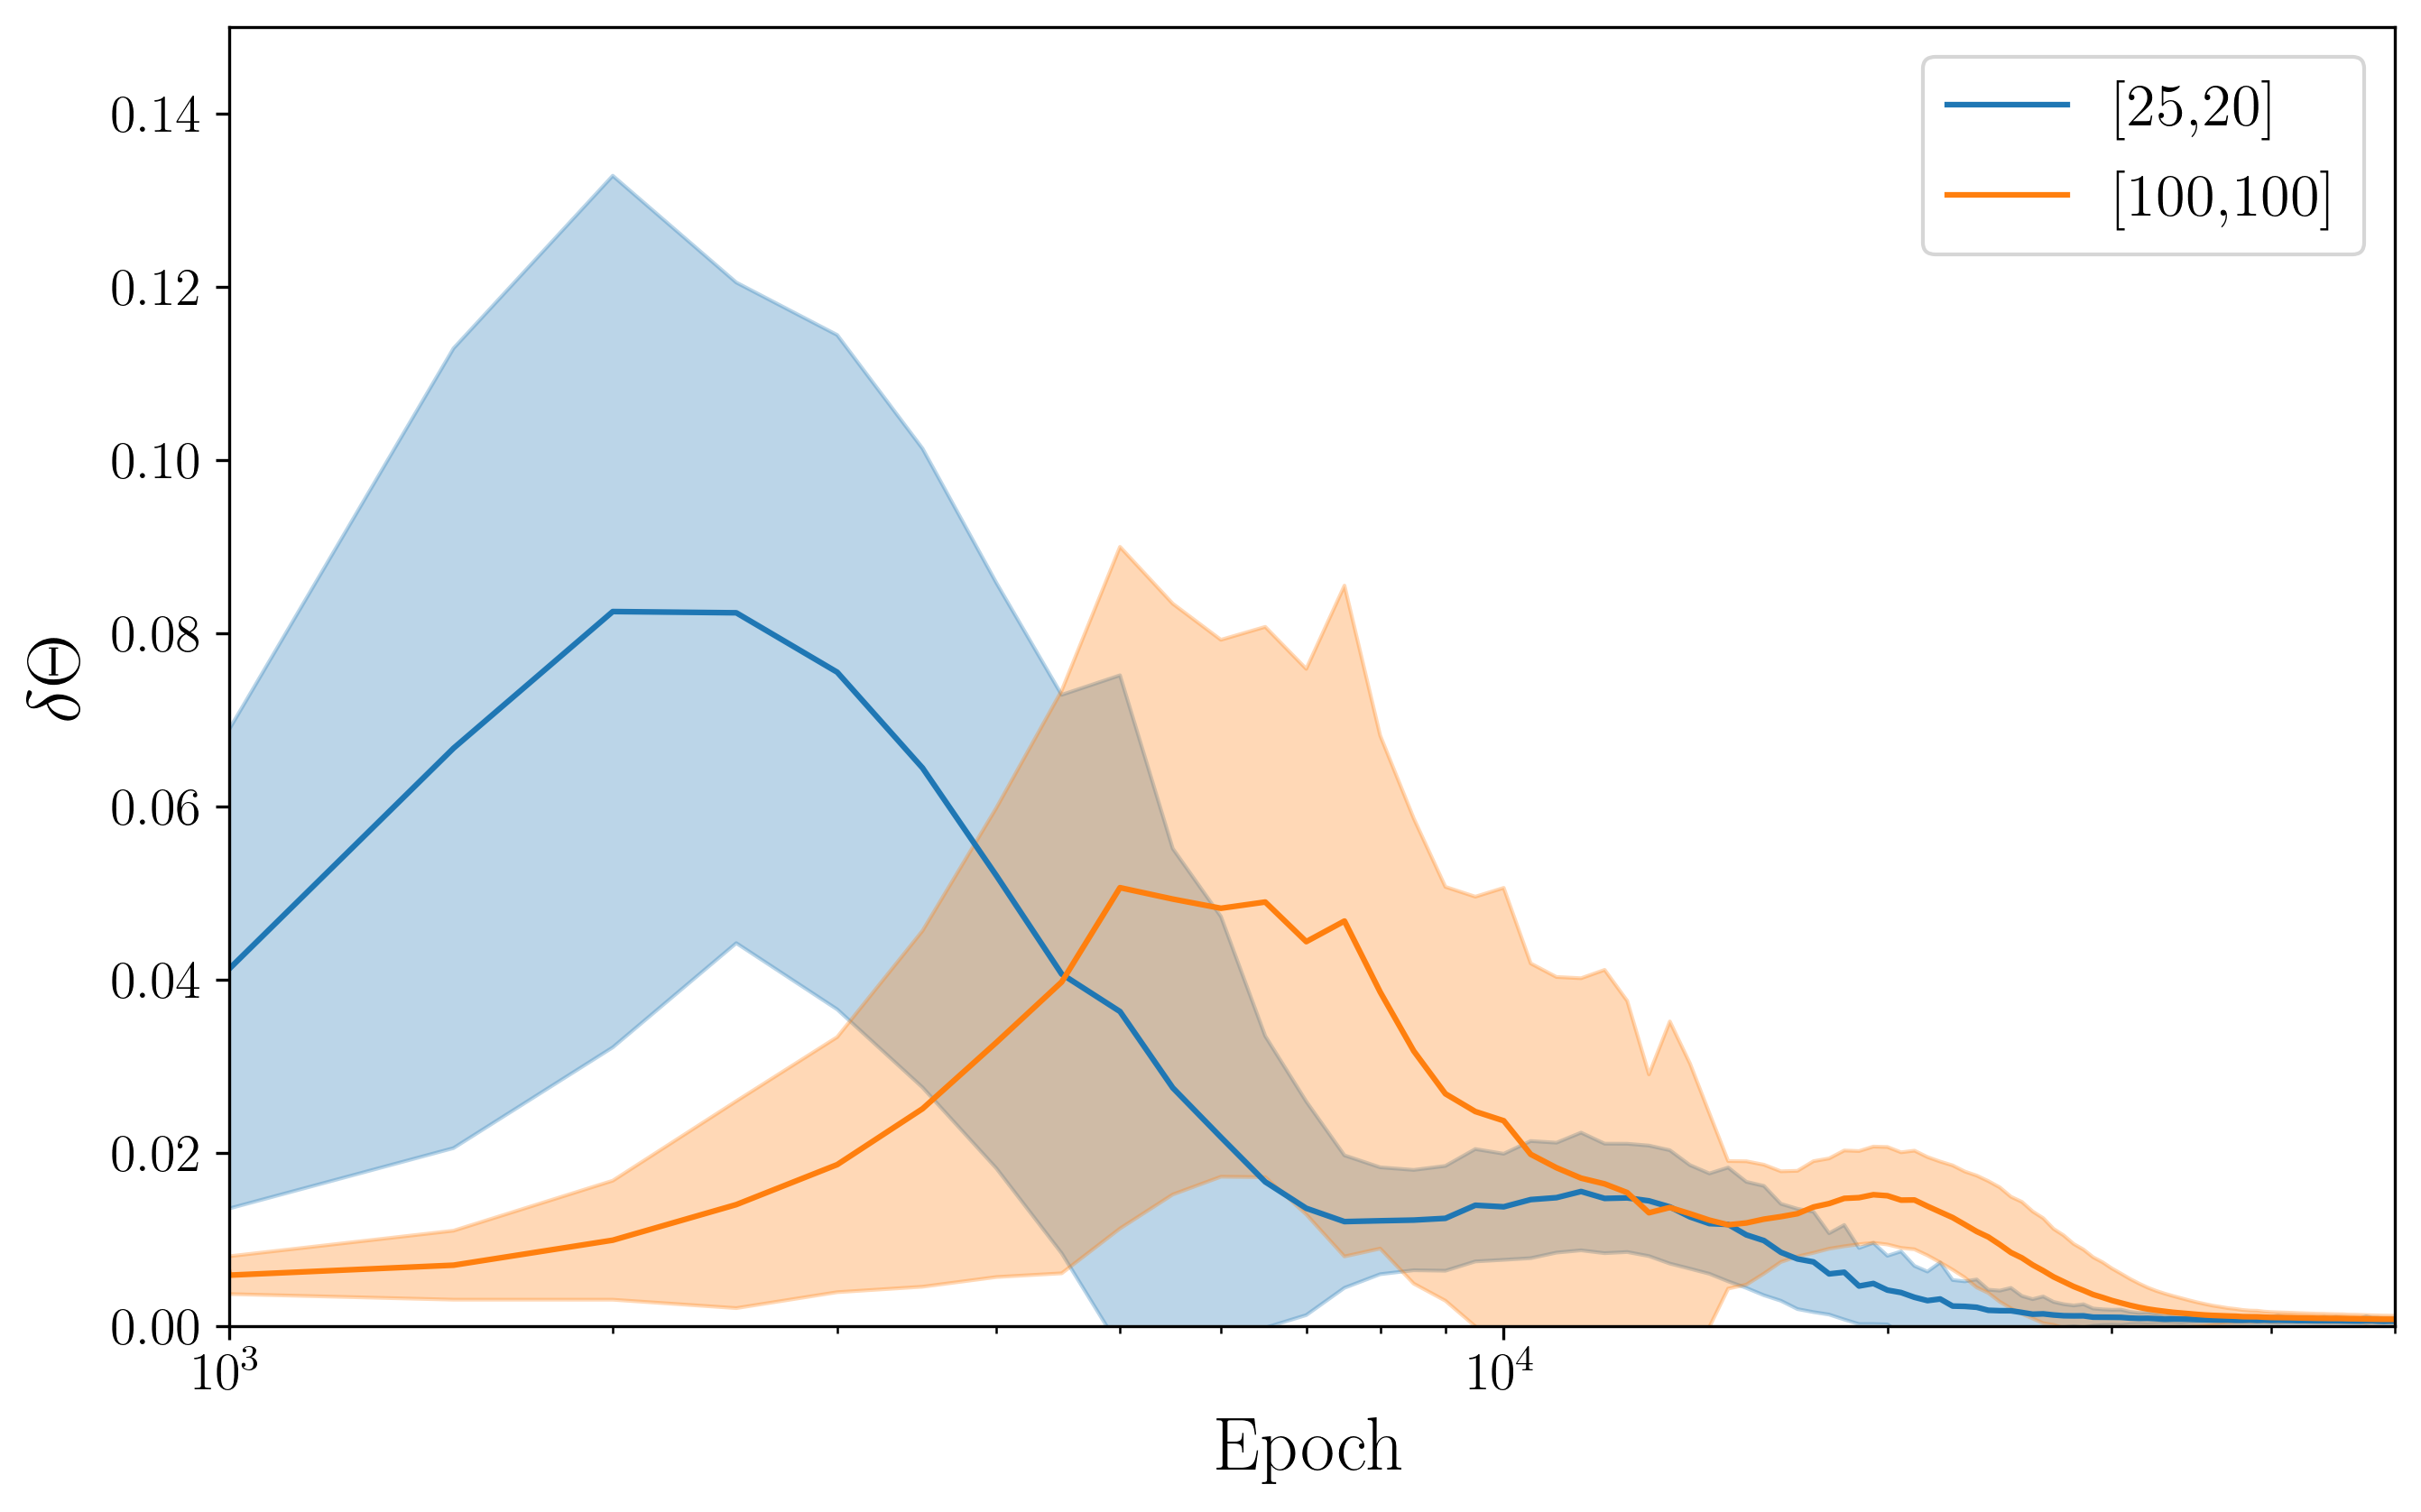

In [127]:
fitlabels = [r"$\textrm{[25,20]}$", r"$\textrm{[100,100]}$"]
fitcolors = ["C0", "C1"]
dist_grids = []
epochs = ctx_L0_old.get_config("replicas", "common_epochs")
for idx, ctx  in enumerate([ctx_L0_old, ctx_L0_large]):
    context = ctx
    data_type = context.get_config("metadata", "arguments")["data"]
    delta_ntk_distribution_by_epoch = compute_delta_ntk(context)
    # assert np.array_equal(epochs, context.get_config("replicas", "common_epochs")), "Epochs do not match across fits."
    dist_grids.append(delta_ntk_distribution_by_epoch)


fig = plt.figure(figsize=FIGRATIO*2)
ax = fig.add_subplot(111)
plt.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.95)

produce_plot(
  epochs[1::],
  dist_grids,
  xlabel=r"${\rm Epoch}$",
  ylabel=r"$\delta \Theta$",
  labels=fitlabels,
  colors=fitcolors,
  ax=ax
)

ax.set_xscale("log")
ax.set_ylim(0., 0.15)
ax.set_xlim(1e3, 5e4)
fig.savefig(THIS / "appendix_arch/delta_ntk_arch.pdf", bbox_inches="tight")

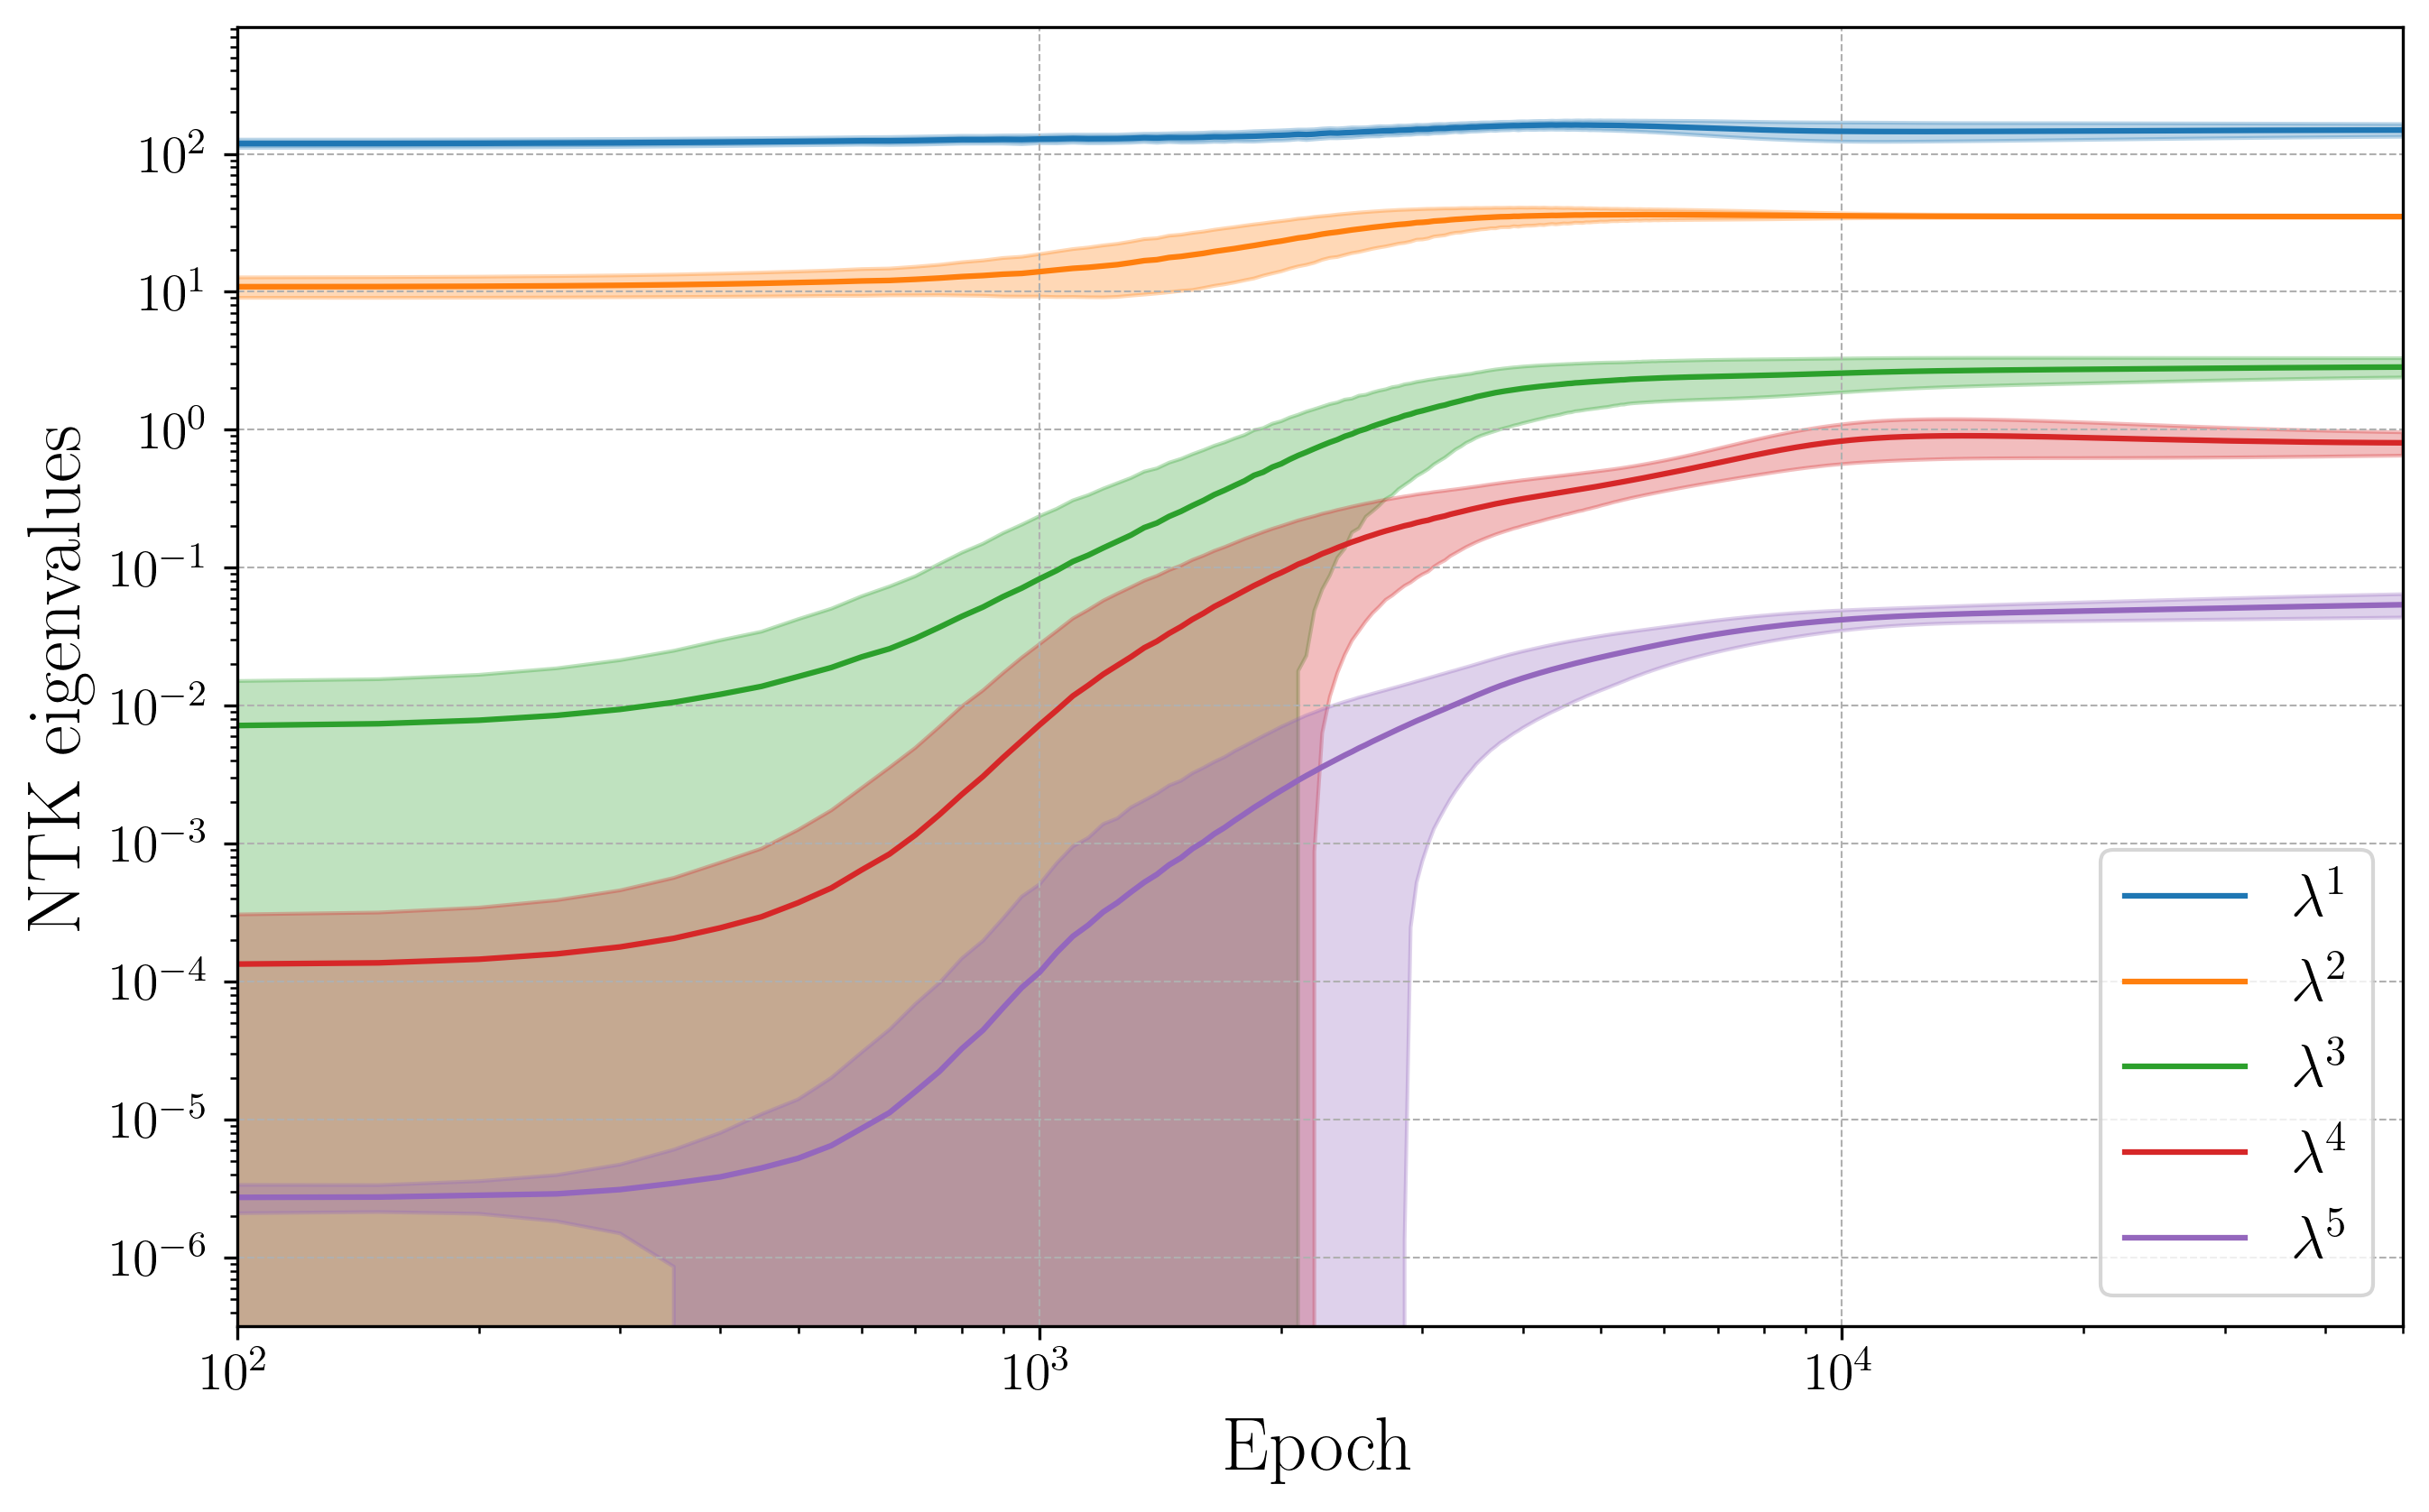

In [ ]:
from yadlt.utils import combine_distributions

fig = plt.figure(figsize=FIGRATIO*2)
ax = fig.add_subplot(111)
plt.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.95)

ctx = context_L0

ylabel = "$\\textrm{NTK eigenvalues}$"
labels = ["$\\lambda^{1}$", "$\\lambda^{2}$", "$\\lambda^{3}$", "$\\lambda^{4}$", "$\\lambda^{5}$"]
colors = ["C0", "C1", "C2", "C3", "C4"]
eigvals = [1, 2, 3, 4, 5]
eigval = combine_distributions(ctx.eigvals_time)
all_slices = [eigval.slice((slice(None), idx_eig - 1)) for idx_eig in eigvals]

produce_plot(
    epochs,
    all_slices,
    scale="linear",
    colors=colors,
    labels=labels,
    xlabel=r"${\rm Epoch}$",
    ylabel=ylabel,
    ax=ax
)

ax.grid(True, which="major", linestyle="--", linewidth=0.5)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(1e2, 5e4)
fig.savefig(THIS / "section_3/ntk_initialization_L0.pdf", bbox_inches="tight")

In [ ]:
from yadlt.utils import combine_distributions

fig = plt.figure(figsize=FIGRATIO*2)
ax = fig.add_subplot(111)
plt.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.95)

ctx_nnpdf = ctx_L0_old
ctx_large = ctx_L0_large

ylabel = "$\\textrm{NTK eigenvalues}$"
fitlabels = [r"$\textrm{[25,20]}$", r"$\textrm{[100,100]}$"]
fitcolors = ["C0", "C1"]
eigvals = [1, 2, 3]
eigval = combine_distributions(ctx.eigvals_time)
all_slices = [eigval.slice((slice(None), idx_eig - 1)) for idx_eig in eigvals]

produce_plot(
    epochs,
    all_slices,
    scale="linear",
    colors=colors,
    labels=labels,
    xlabel=r"${\rm Epoch}$",
    ylabel=ylabel,
    ax=ax
)

ax.grid(True, which="major", linestyle="--", linewidth=0.5)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(1e2, 5e4)
fig.savefig(THIS / "section_3/ntk_eigvals_single_plot_L0.pdf", bbox_inches="tight")

In [108]:
eigvals1_by_ctx = []
eigvals2_by_ctx = []
eigvals3_by_ctx = []
eigvals4_by_ctx = []
eigvals5_by_ctx = []

for ctx in [context_L0, context_L1, context_L2]:
    eigval = combine_distributions(ctx.eigvals_time)
    eigvals1_by_ctx.append(eigval.slice((slice(None), 0)))
    eigvals2_by_ctx.append(eigval.slice((slice(None), 1)))
    eigvals3_by_ctx.append(eigval.slice((slice(None), 2)))
    eigvals4_by_ctx.append(eigval.slice((slice(None), 3)))
    eigvals5_by_ctx.append(eigval.slice((slice(None), 4)))

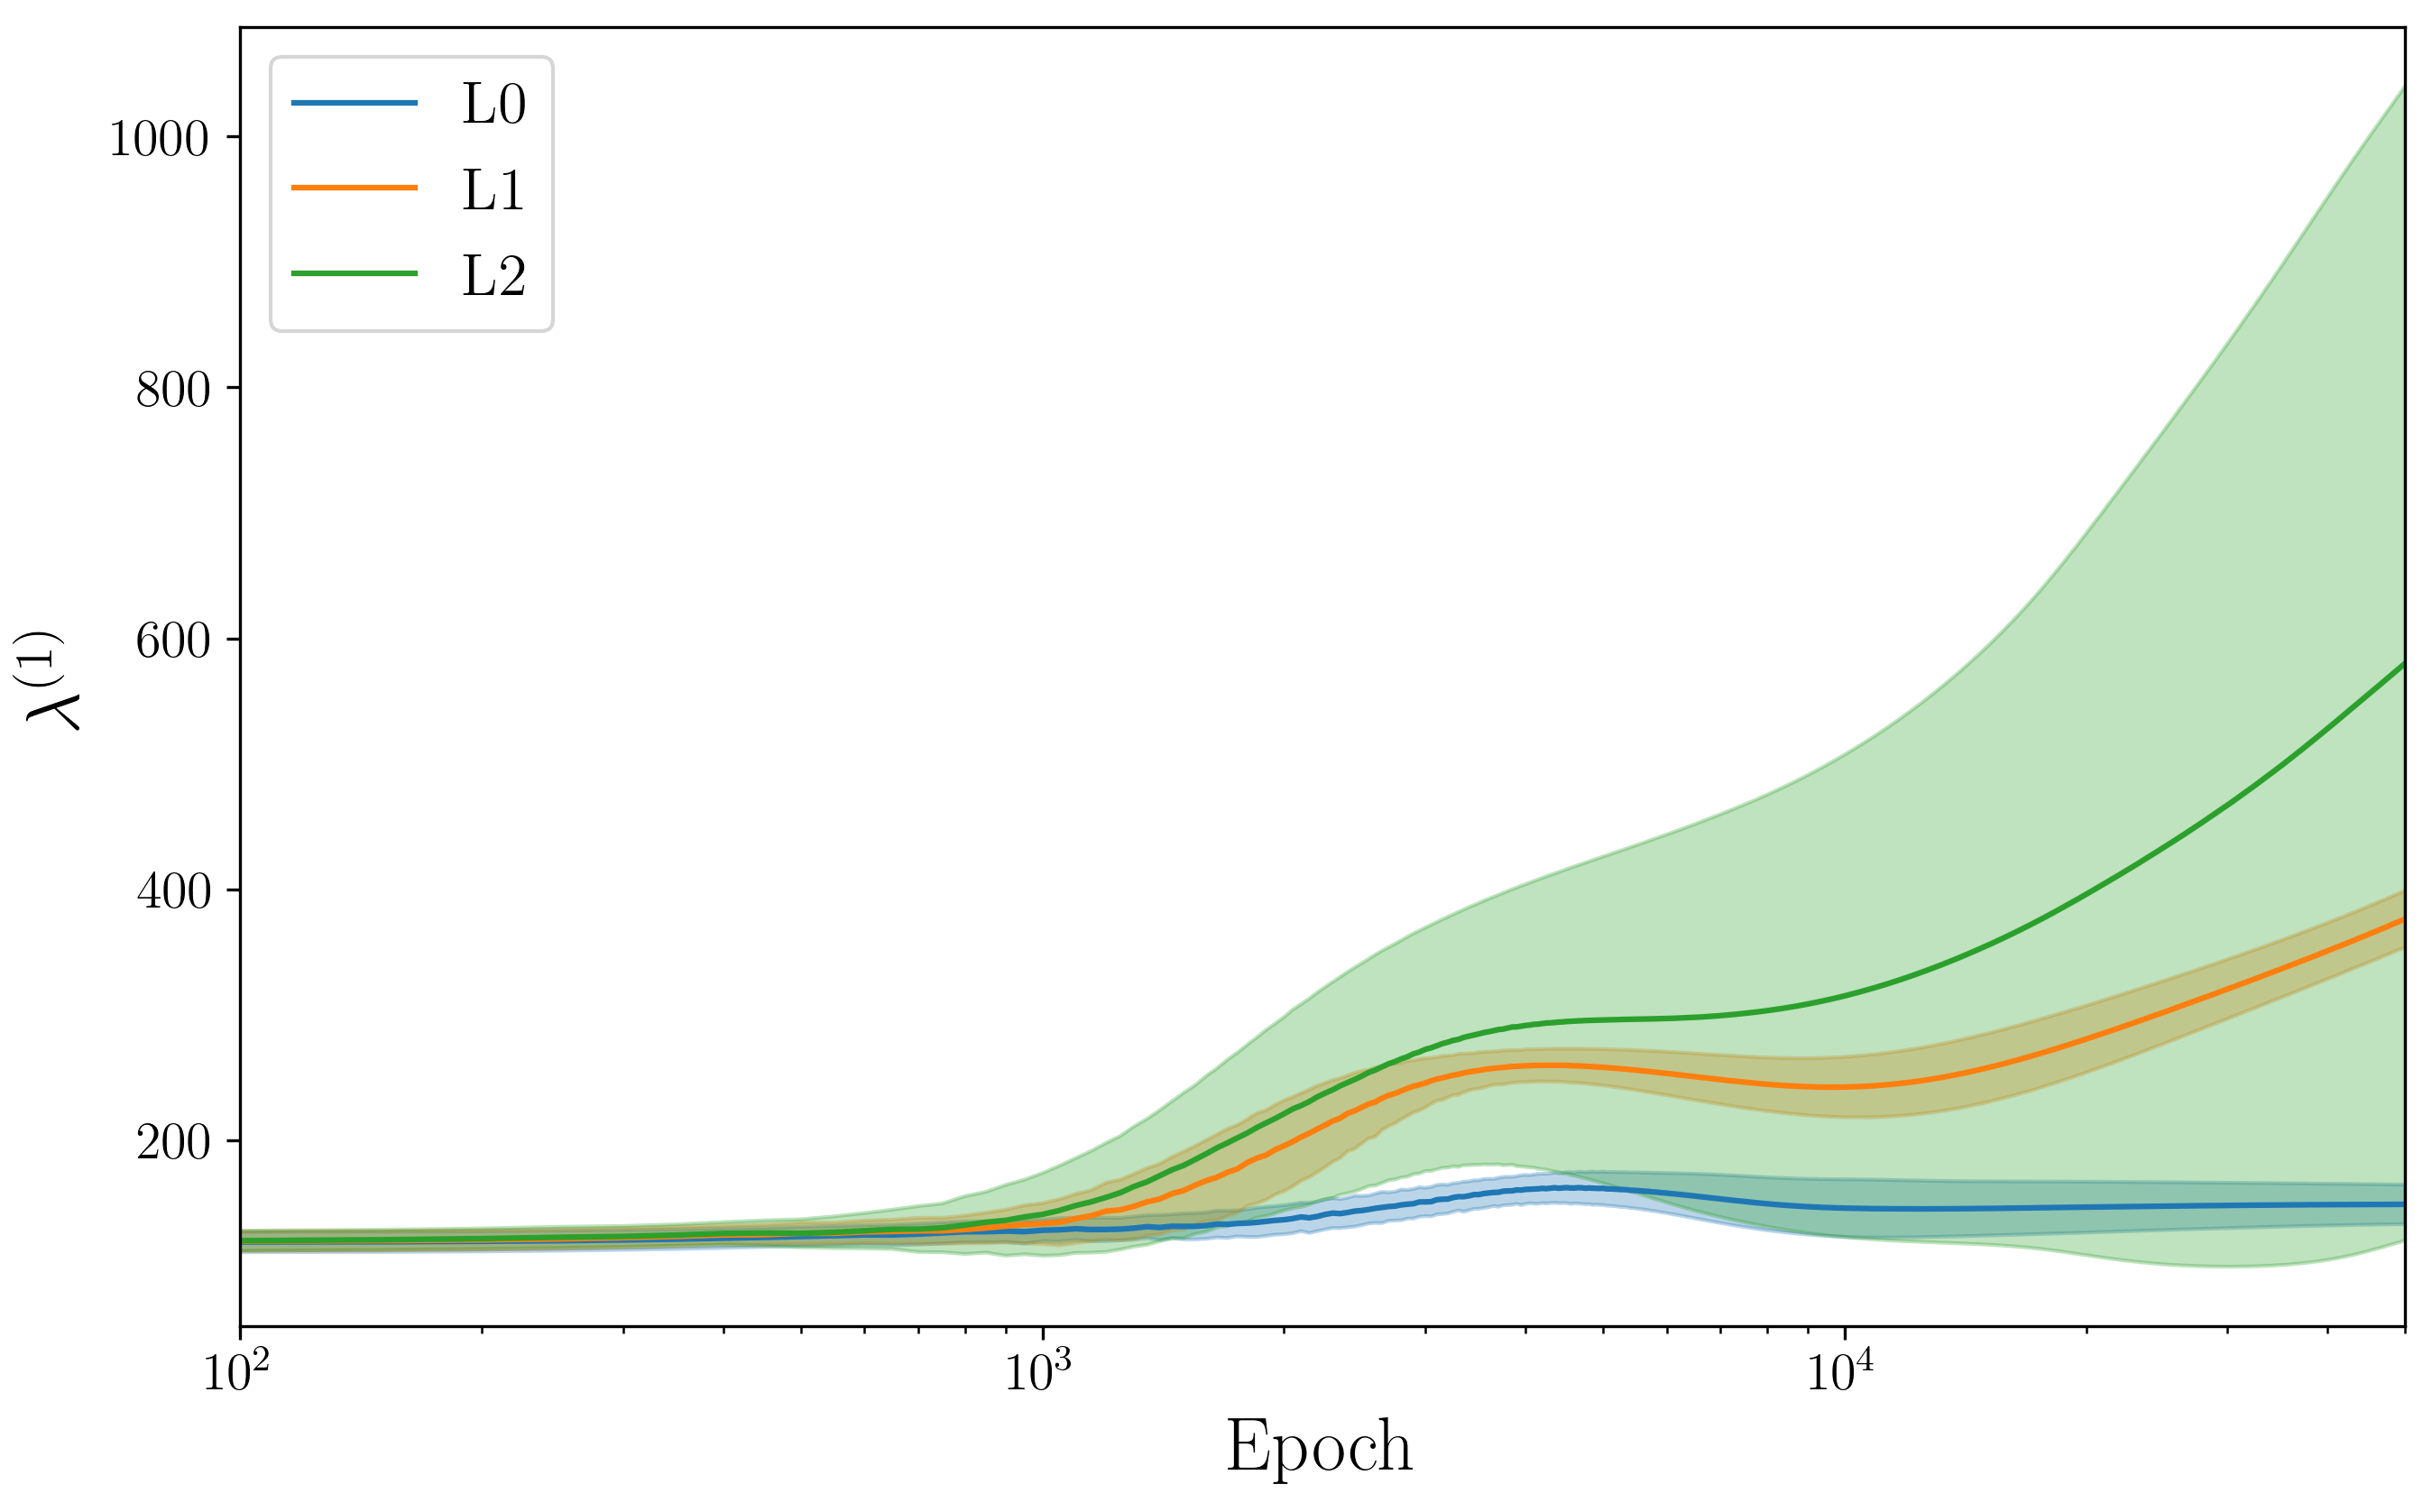

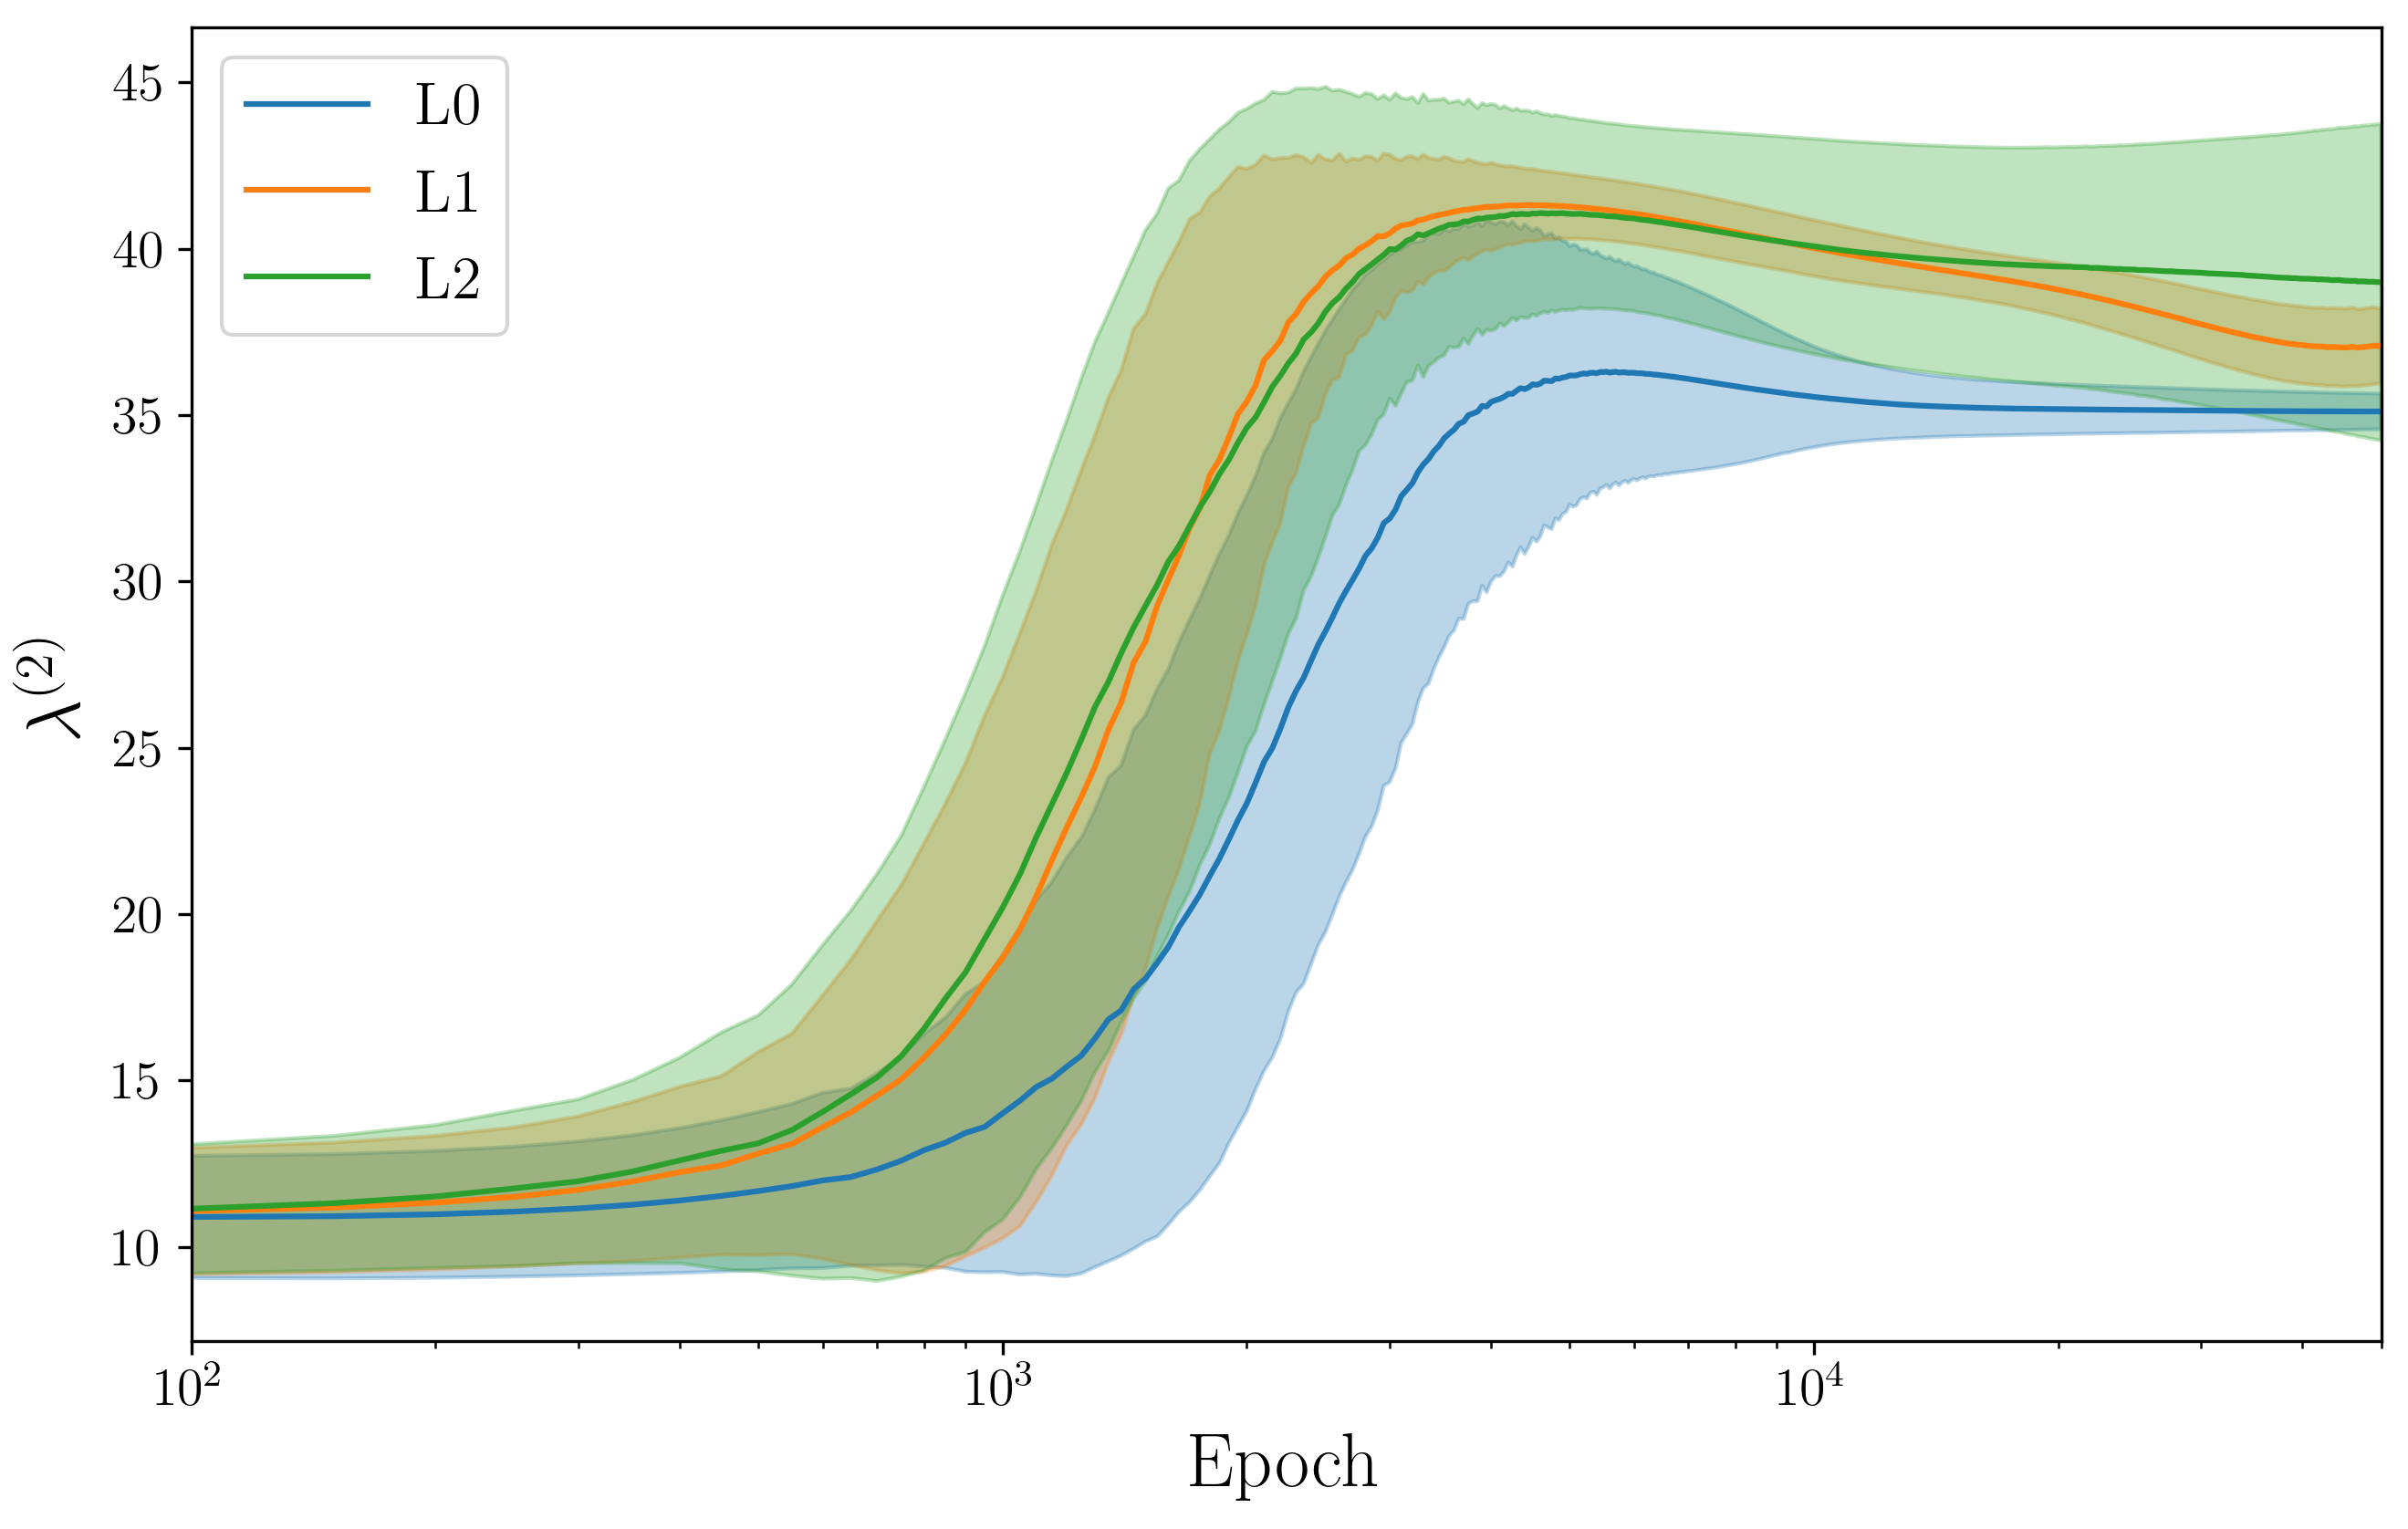

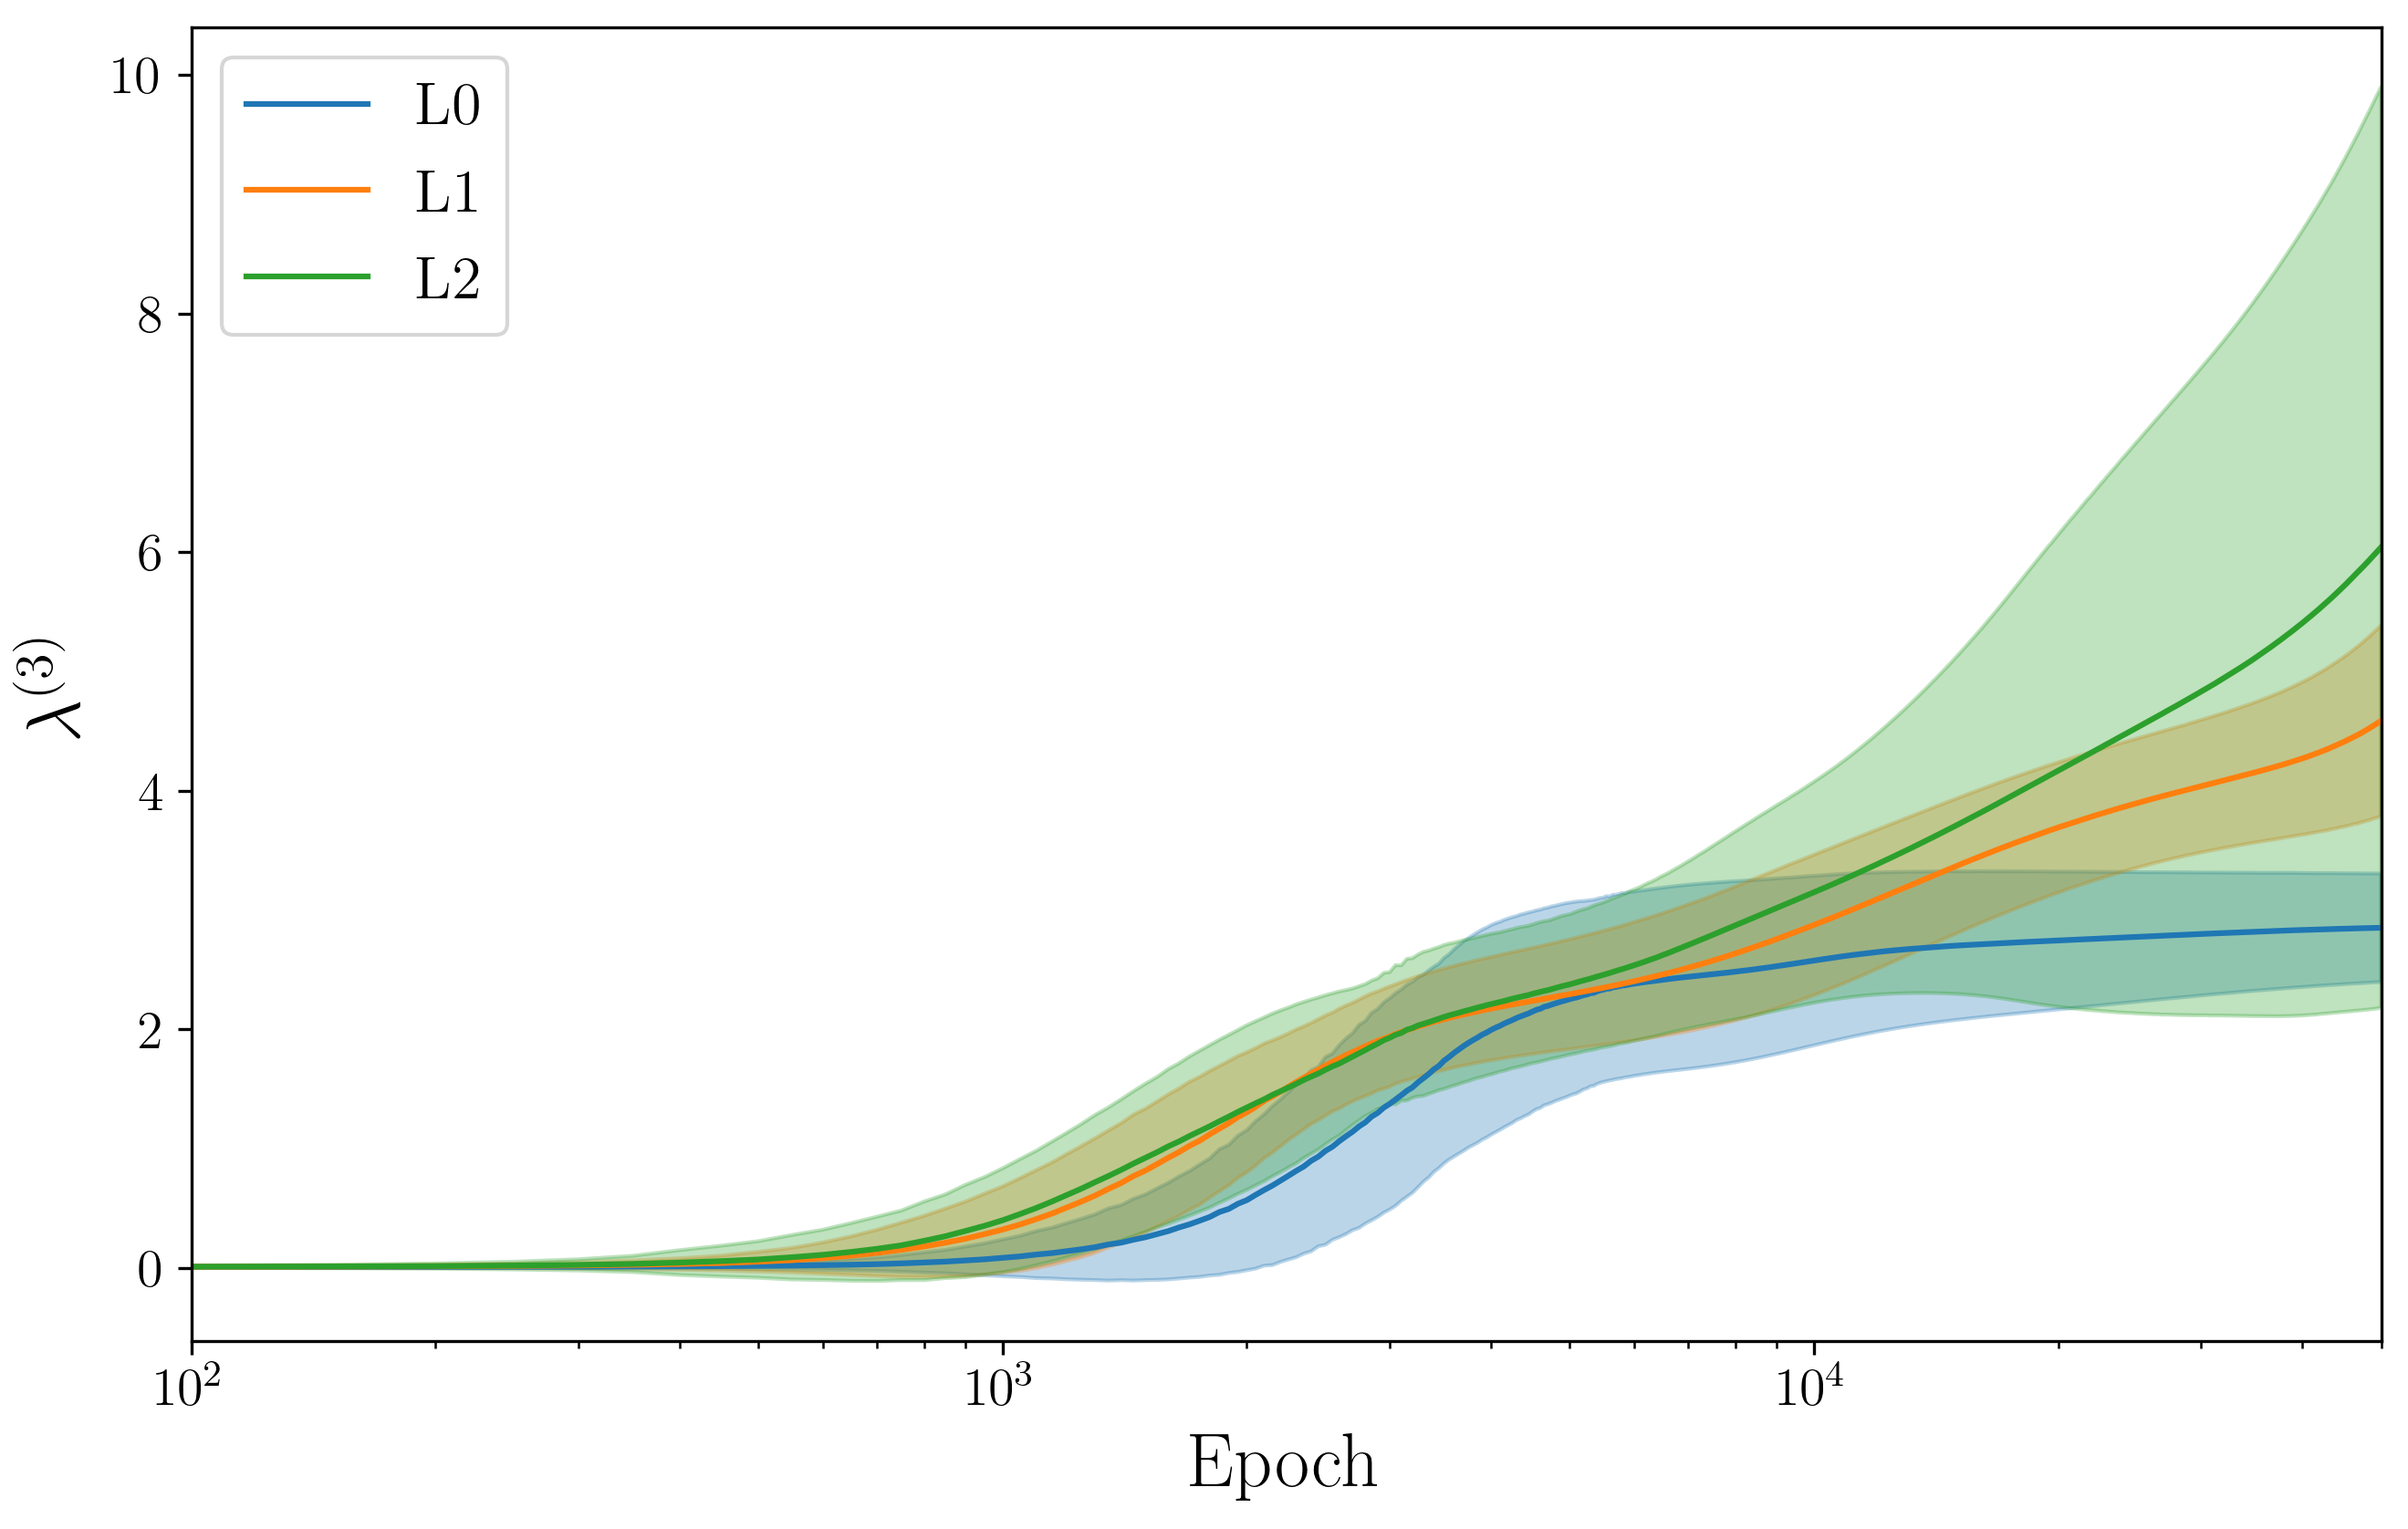

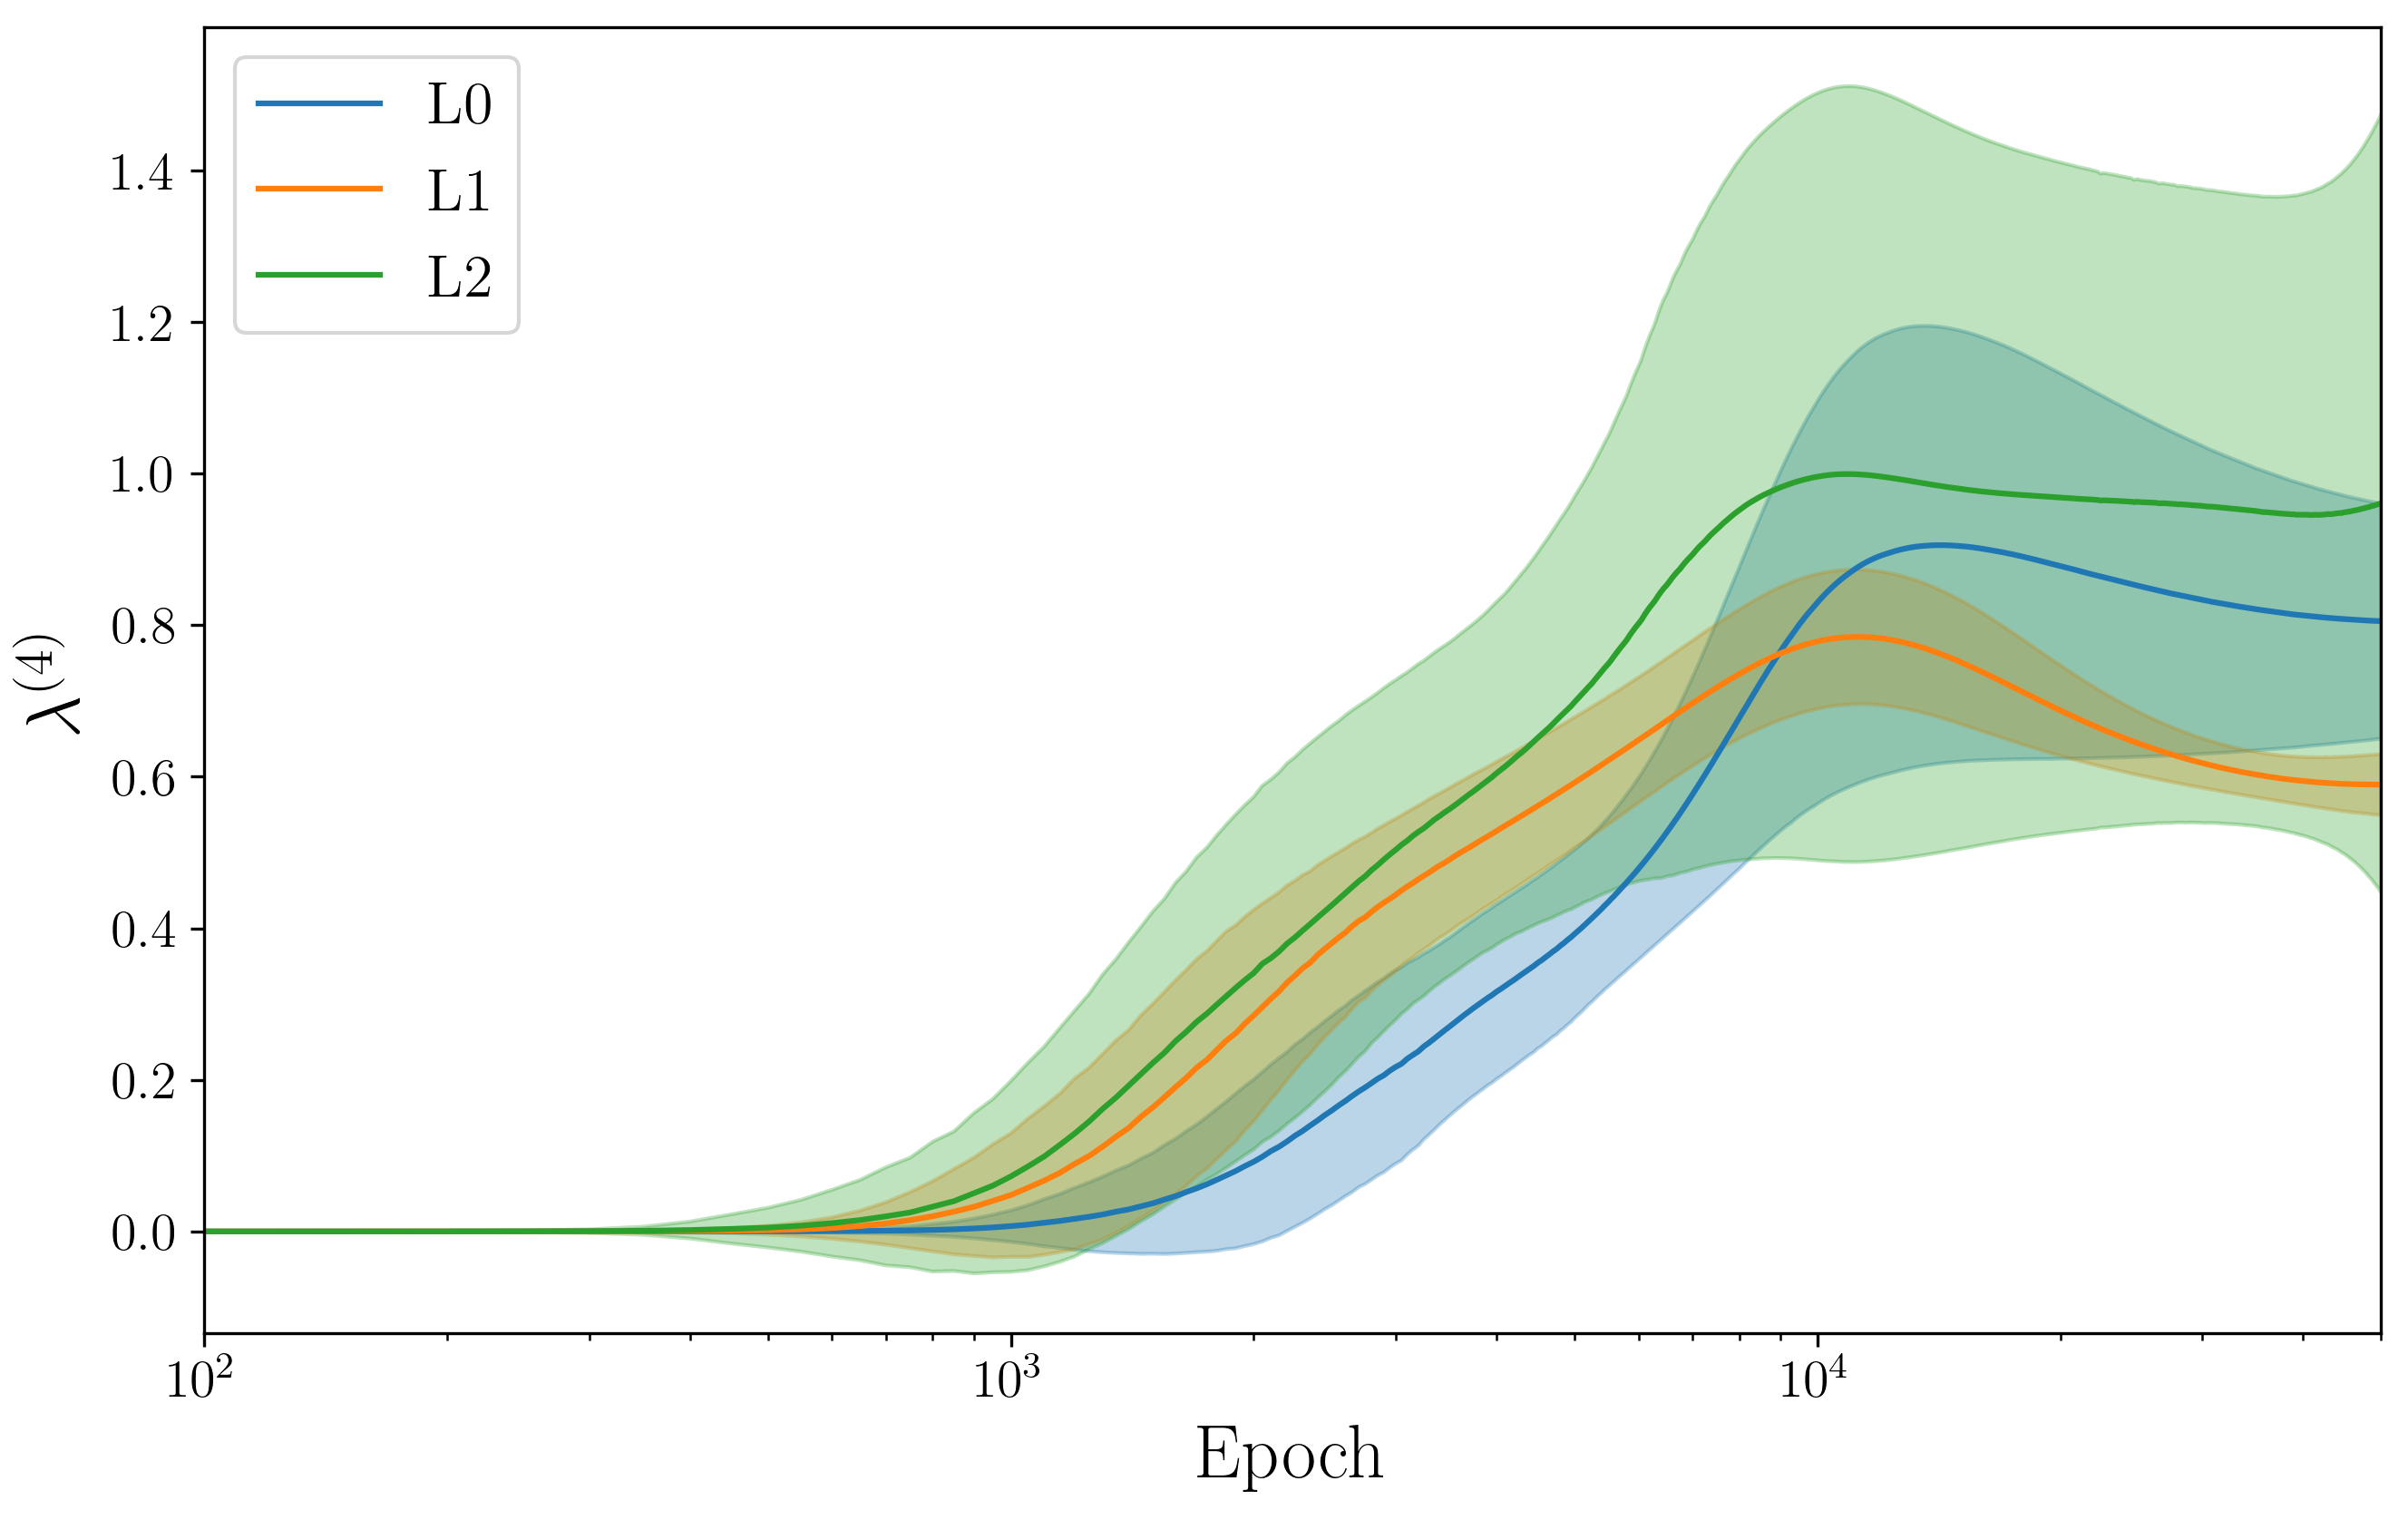

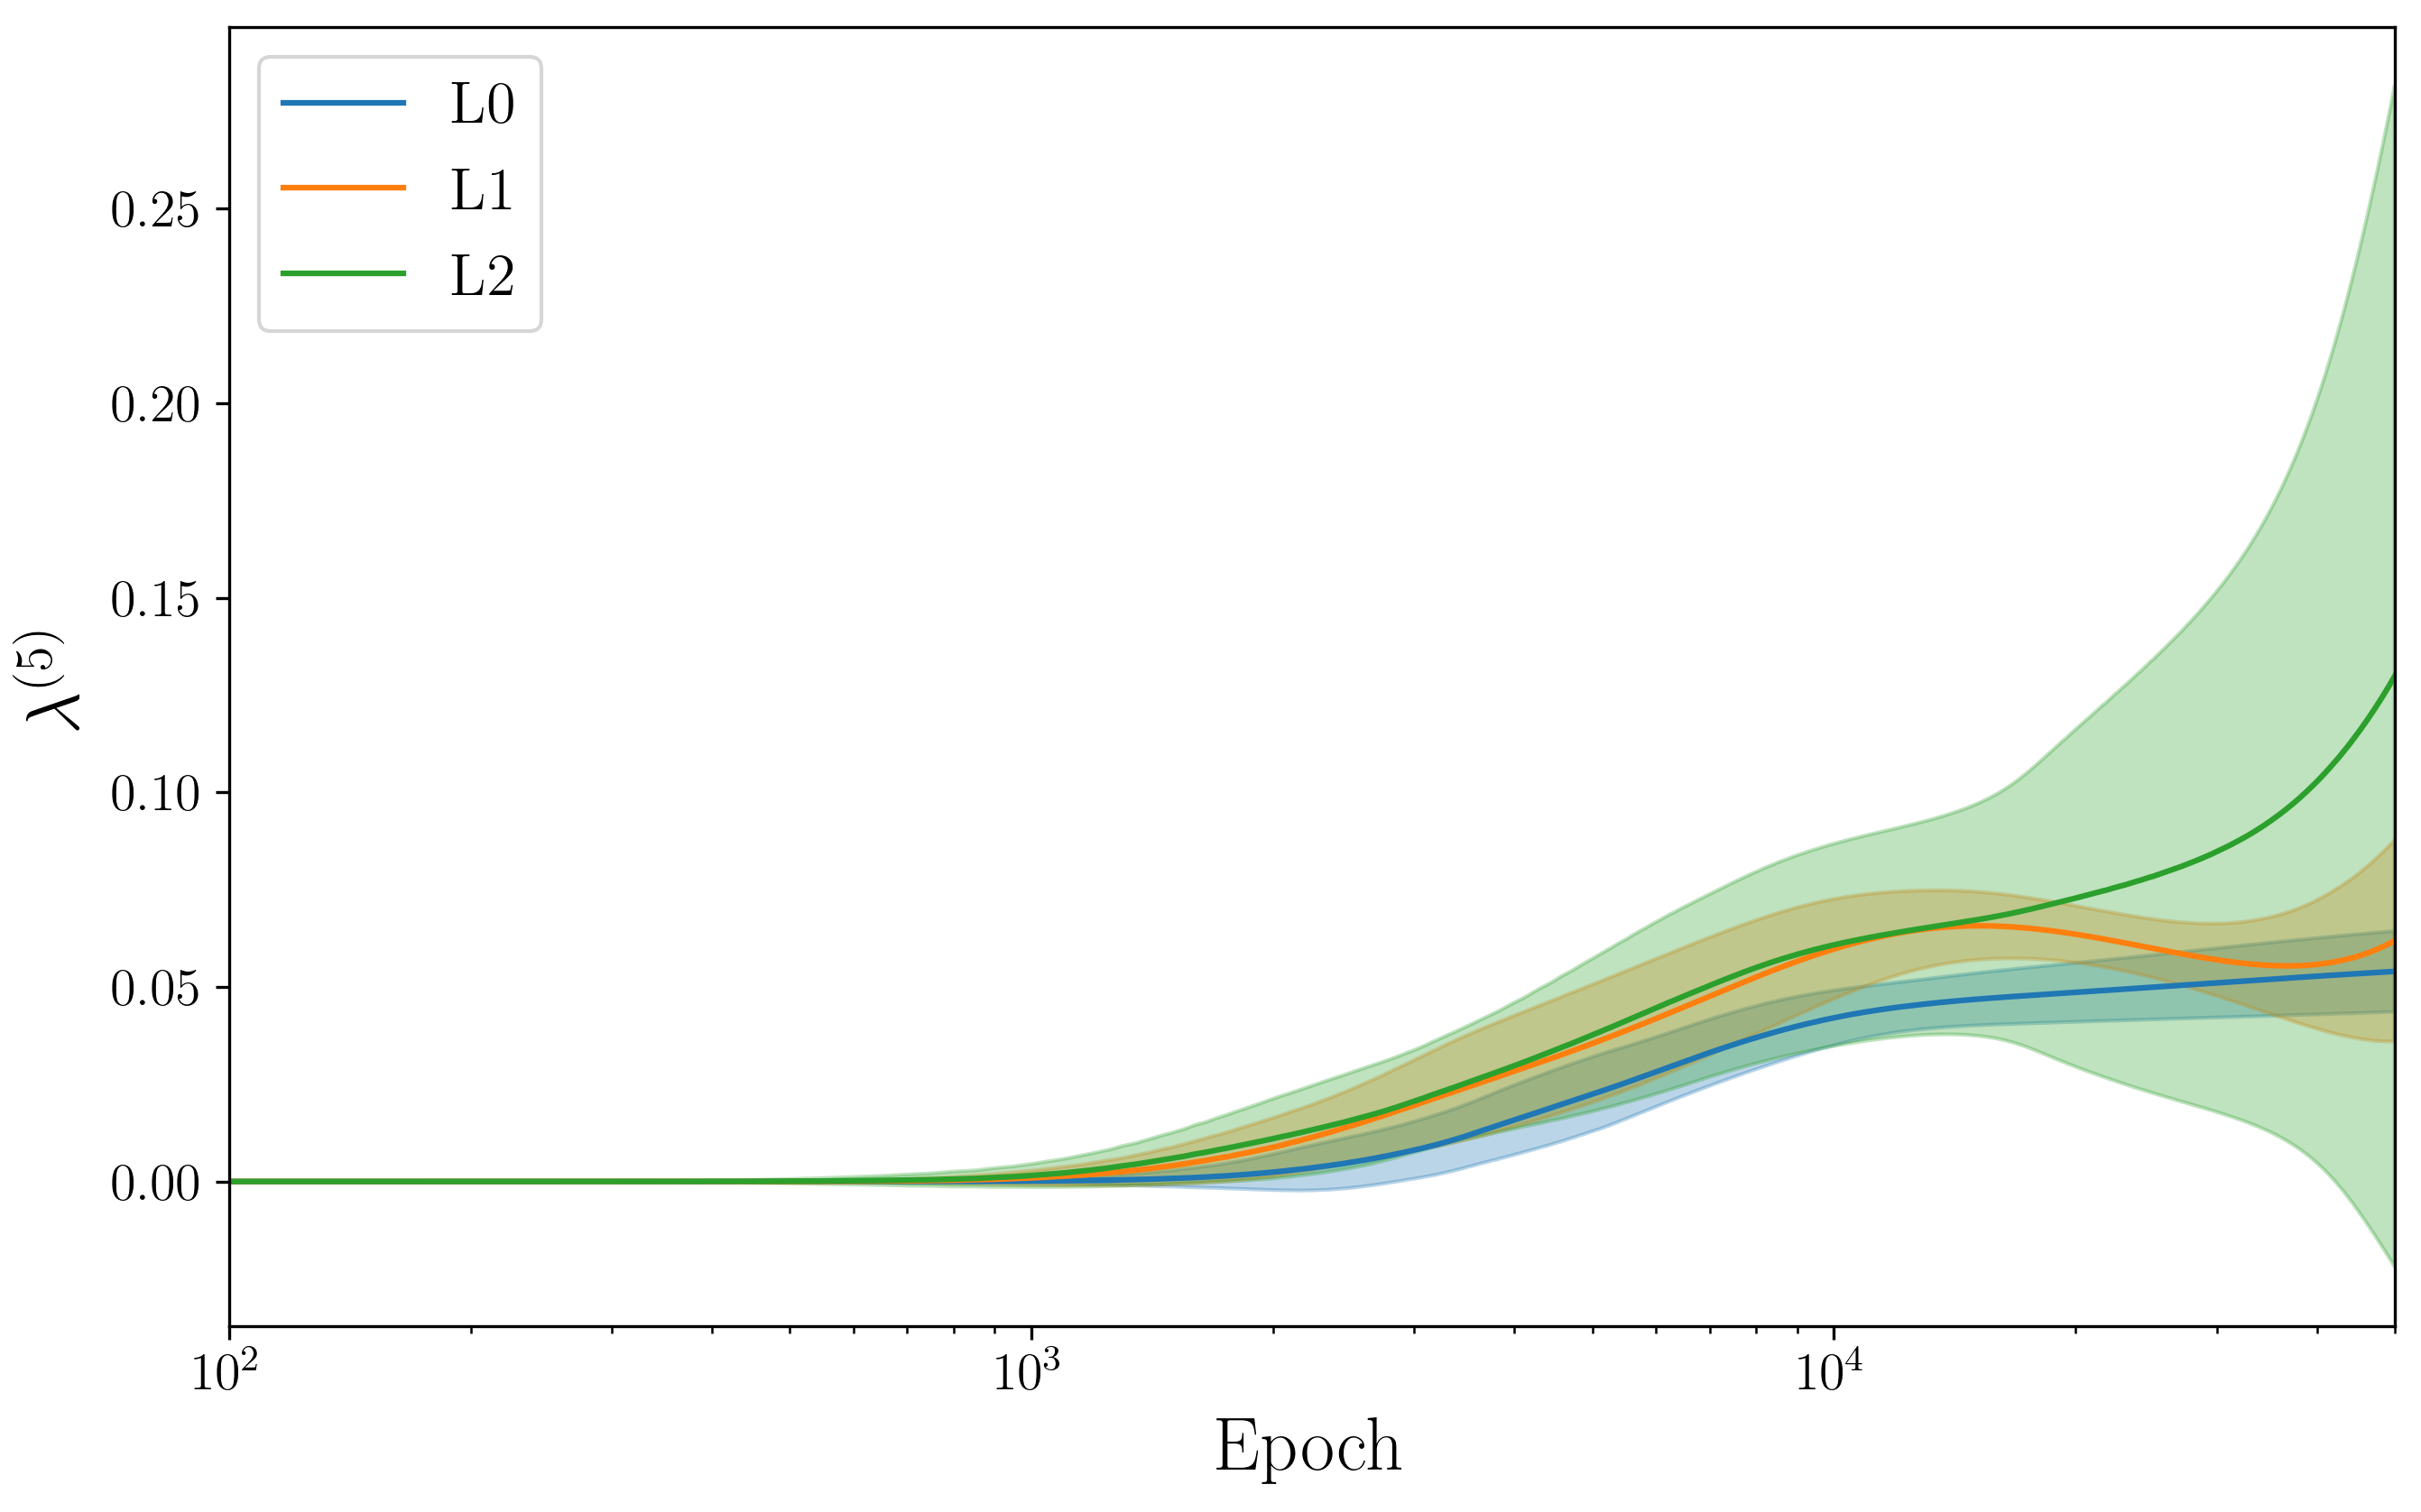

In [115]:
list_of_eigvals_by_ctx = [
    eigvals1_by_ctx,
    eigvals2_by_ctx,
    eigvals3_by_ctx,
    eigvals4_by_ctx,
    eigvals5_by_ctx,
]

for idx in range(5):
  fig = plt.figure(figsize=FIGRATIO*2)
  ax = fig.add_subplot(111)
  plt.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.95)

  produce_plot(
      epochs,
      list_of_eigvals_by_ctx[idx],
      scale="linear",
      colors=["C0", "C1", "C2"],
      labels=["$\\textrm{L0}$", "$\\textrm{L1}$", "$\\textrm{L2}$"],
      xlabel=r"${\rm Epoch}$",
      ylabel=rf"$\lambda^{{({idx+1})}}$",
      ax=ax
  )

  ax.set_xscale("log")
  ax.set_xlim(1e2, 5e4)
  fig.savefig(THIS / f"section_3/ntk_eigvals_L0_L1_L2_n_{idx+1}.pdf", bbox_inches="tight")

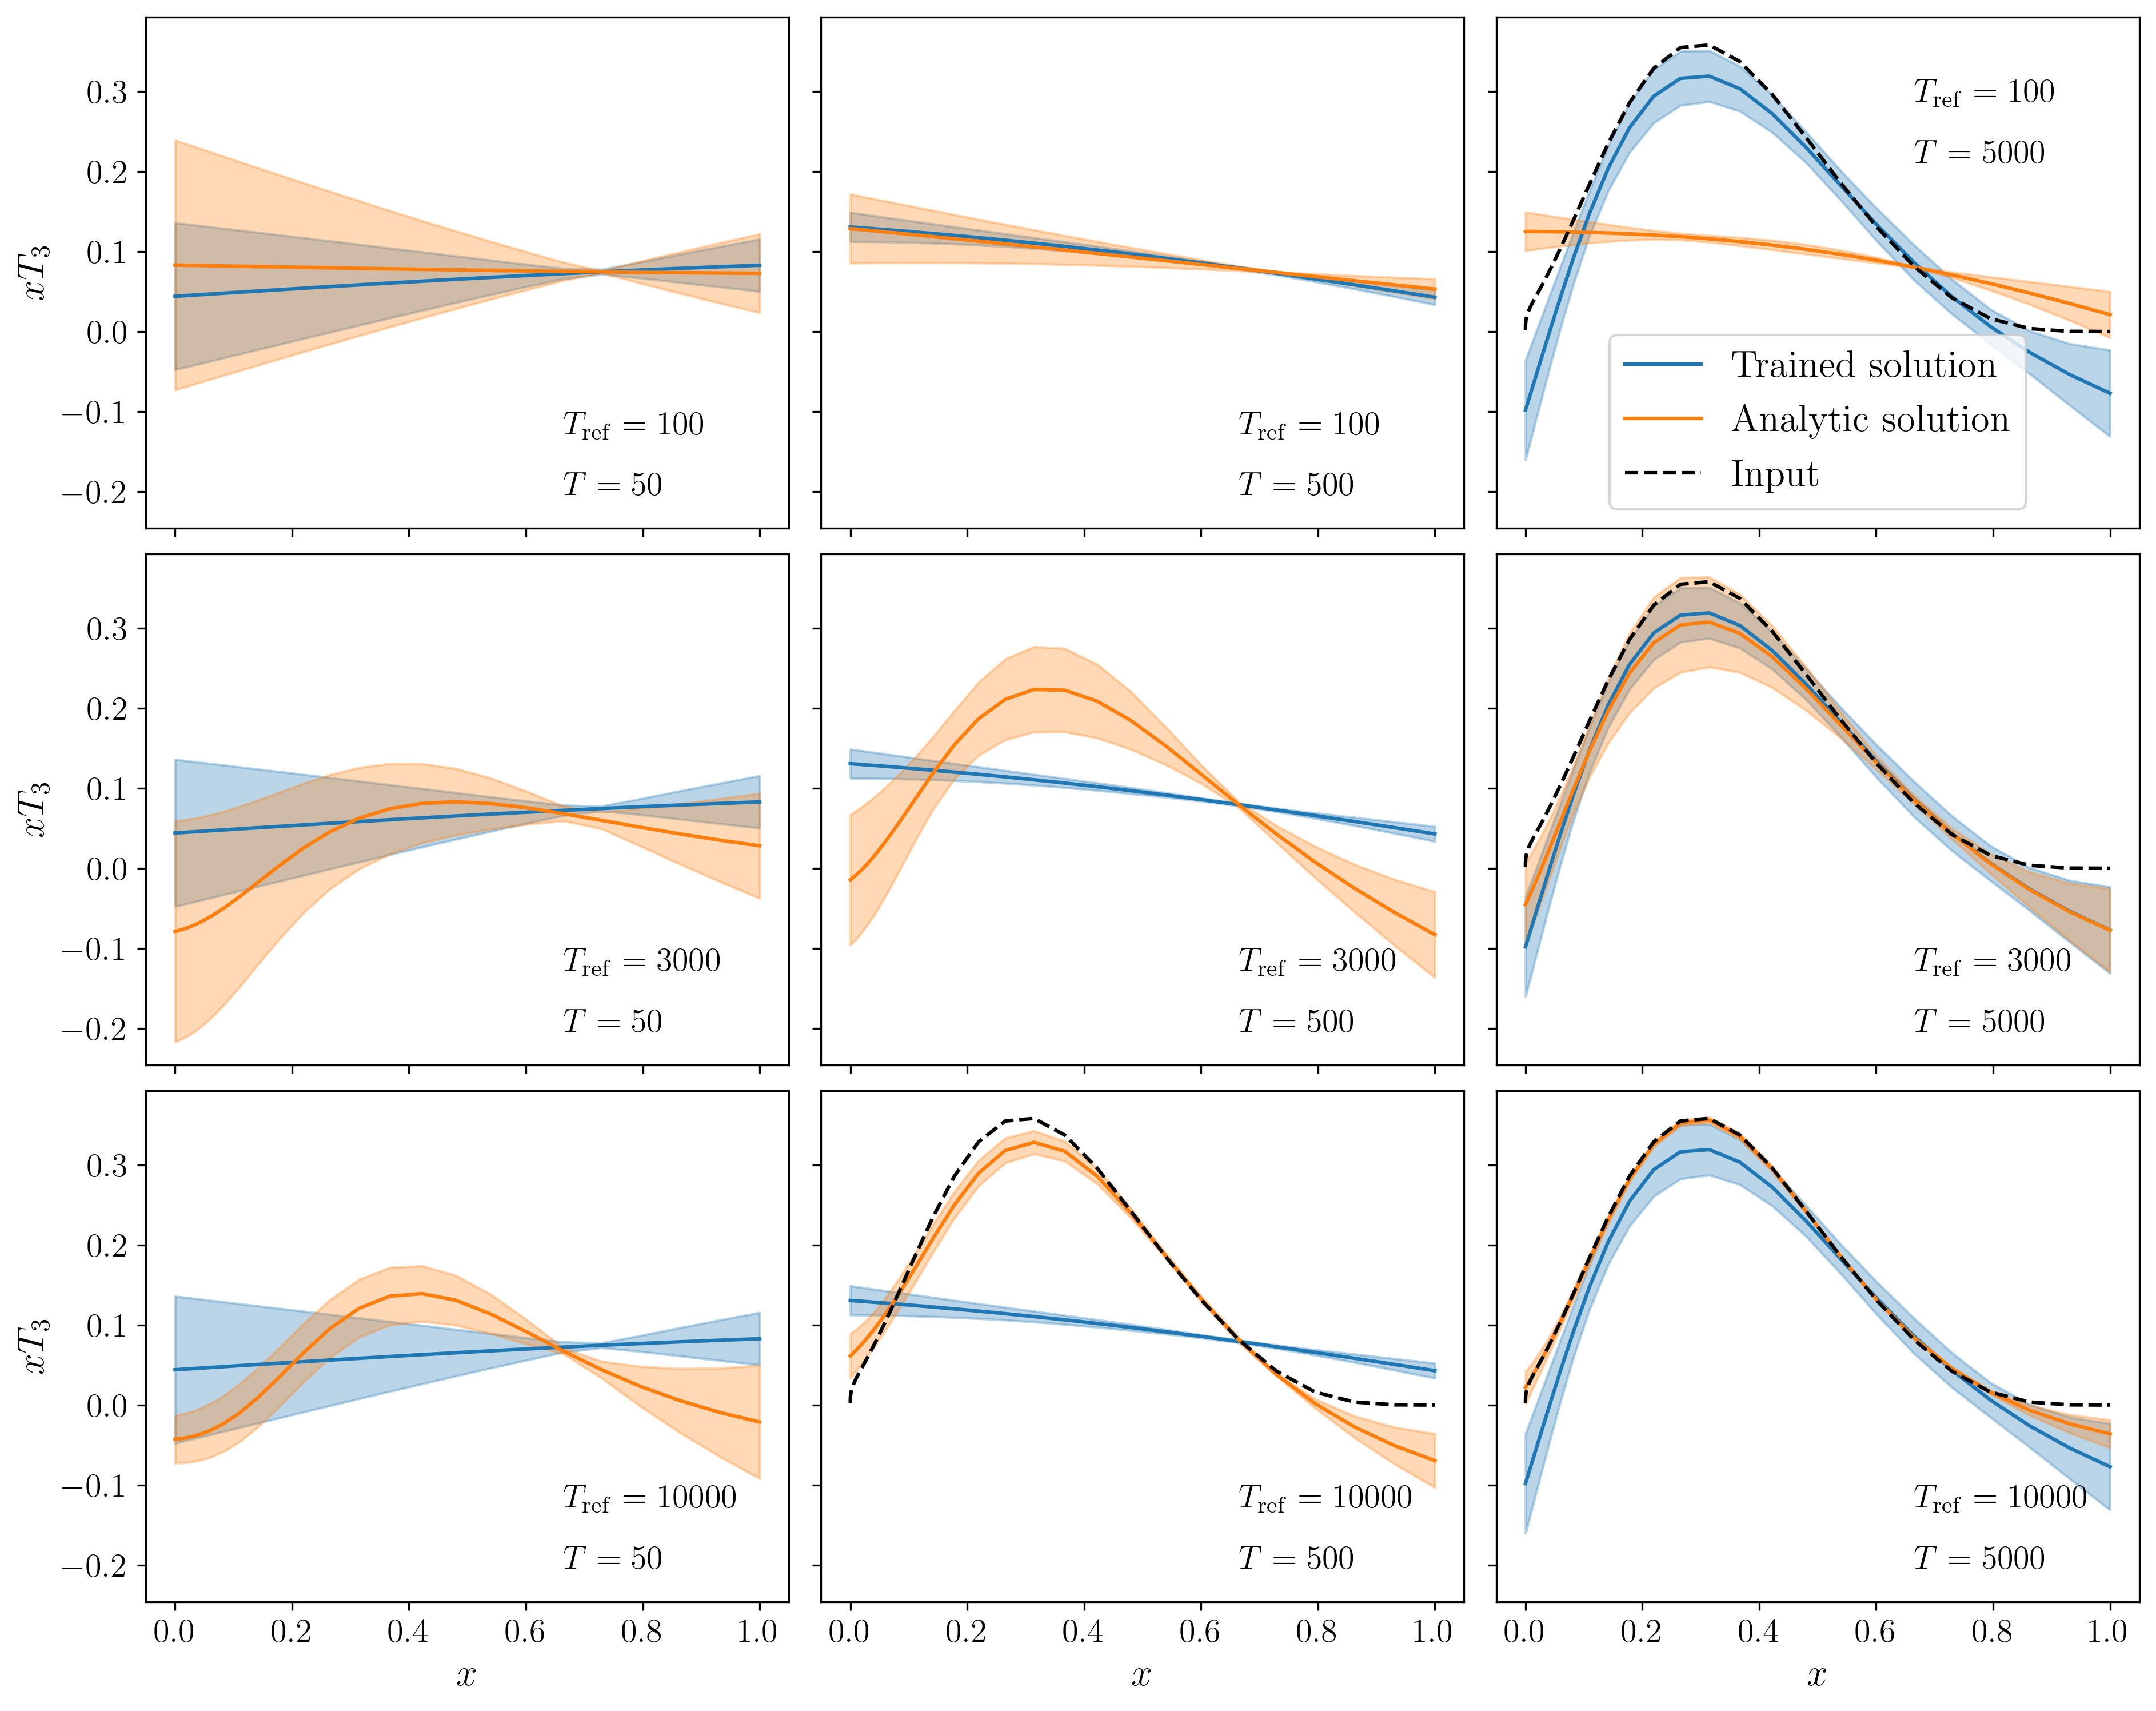

In [116]:
from yadlt.plotting.plot_evolution_pdf import plot_evolution_vs_trained

ref_epochs=[100, 3000, 10000]
epochs=[50, 500, 5000]

nrows = len(ref_epochs)
ncols = len(epochs)
figsize = (5, 4)
subplot_adjust = {"sharex": True, "sharey": True, 'gridspec_kw': {'wspace':0.05, 'hspace':0.05}}

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * figsize[0], nrows * figsize[1]), **subplot_adjust)

for i, ref_epoch in enumerate(ref_epochs):
    for j, epoch in enumerate(epochs):
      ax = axes[i, j]
      plot_evolution_vs_trained(
        context_L0,
        ref_epoch=ref_epoch,
        labels=[r"$\textrm{Trained solution}$", r"$\textrm{Analytic solution}$"],
        epoch=epoch,
        show_true=True if (j == ncols - 1 or (j == 1 and i == 2)) else False,
        ax=ax,
      )
      
      ax.set_title(None)
      ax.set_xlabel(r"$x$", fontsize=16)

      if i != 0 or j != ncols-1:
         ax.get_legend().set_visible(False)
         ax.text(0.65, 0.2, rf"$T_{{\rm ref}} = {{{ref_epoch}}}$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=14)
         ax.text(0.65, 0.08, rf"$T = {{{epoch}}}$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=14)
      else:
         ax.text(0.65, 0.85, rf"$T_{{\rm ref}} = {{{ref_epoch}}}$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=14)
         ax.text(0.65, 0.73, rf"$T = {{{epoch}}}$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=14)
         lg = ax.get_legend()
         tx = lg.get_texts()[-1]
         tx.set_text(r"$\textrm{Input}$")

      if j == 0:
        ax.set_ylabel(r"$xT_3$", fontsize=16)
         

# fig.savefig("evolution_vs_trained_grid_L0.pdf", bbox_inches='tight')

In [ ]:
from yadlt.plotting.plot_covariance import plot_diag_error_decomposition

ref_epochs=[100, 3000, 10000]
epochs=[1, 10, 100]

common_spec = {
  "alpha": 0.5,
  "marker": "X",
  "markersize": 5,
  "lw": 2.0,
  "capthick": 2,
  "capsize": 3,
  "linestyle": "None",
}

nrows = len(ref_epochs)
ncols = len(epochs)
figsize = (5, 4)
subplot_adjust = {"sharex": True, "sharey": True, 'gridspec_kw': {'wspace':0.05, 'hspace':0.05}}

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * figsize[0], nrows * figsize[1]), **subplot_adjust)

for i, ref_epoch in enumerate(ref_epochs):
    for j, epoch in enumerate(epochs):
      ax = axes[i, j]
      plot_diag_error_decomposition(
        context_L2,
        ref_epoch=ref_epoch,
        epoch=epoch,
        # labels=[r"$\textrm{Trained solution}$", r"$\textrm{Analytic solution}$"],
        common_plt_spec=common_spec,
        ax=ax,
      )
      
      ax.set_title(None)
      ax.set_xlabel(r"$x$", fontsize=16)

      if i != 0 or j != ncols-1:
         ax.get_legend().set_visible(False)
         ax.text(0.65, 0.2, rf"$T_{{\rm ref}} = {{{ref_epoch}}}$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=14)
         ax.text(0.65, 0.08, rf"$T = {{{epoch}}}$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=14)
      else:
         ax.text(0.65, 0.85, rf"$T_{{\rm ref}} = {{{ref_epoch}}}$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=14)
         ax.text(0.65, 0.73, rf"$T = {{{epoch}}}$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=14)

      if j == 0:
        ax.set_ylabel(r"$\sigma_{xT_3}$", fontsize=16)
         

fig.savefig("error_buddget_L2.pdf", bbox_inches='tight')

In [ ]:
from yadlt.plotting.plot_covariance import plot_diag_error_decomposition
from pathlib import Path

common_spec = {
  "alpha": 0.5,
  "marker": "X",
  "markersize": 5,
  "lw": 2.0,
  "capthick": 2,
  "capsize": 3,
  "linestyle": "None",
}

plot_diag_error_decomposition(
  context_L2,
  ref_epoch=10000,
  epoch=10,
  xlabel=r"$x$",
  ylabel=r"$\sigma_{xT_3}$",
  common_plt_spec=common_spec,
  save_fig=True,
  plot_dir=Path("/Users/s2569857/Documents/Physics/PhD/Conferences/NPTwins2025"),
  filename="single_plot_error_bar_1.pdf"
)

plot_diag_error_decomposition(
  context_L2,
  ref_epoch=10000,
  epoch=100,
  xlabel=r"$x$",
  ylabel=r"$\sigma_{xT_3}$",
  common_plt_spec=common_spec,
  save_fig=True,
  plot_dir=Path("/Users/s2569857/Documents/Physics/PhD/Conferences/NPTwins2025"),
  filename="single_plot_error_bar_2.pdf"
)

In [ ]:
from yadlt.plotting.plot_expval_u_f0 import plot_expval_u_f0

epochs = [100, 1000, 5000, 10000]
ref_epoch = 20000

nrows = 1
ncols = len(epochs)
figsize = (5, 4)
subplot_adjust = {"sharex": True, "sharey": True, 'gridspec_kw': {'wspace':0.05, 'hspace':0.05}}

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * figsize[0], nrows * figsize[1]), **subplot_adjust)

for ax, epoch in zip(axes.flat, epochs):
    plot_expval_u_f0(
        context_L2,
        ref_epoch=ref_epoch,
        epoch=epoch,
        colors=["C1", "C2"],
        ax=ax,
    )
    ax.text(0.65, 0.90, fr"$T={epoch}$", transform=ax.transAxes, fontsize=16)
    ax.set_xlabel(r"$x$", fontsize=16)

fig.suptitle(rf"$Uf_0,\quad T_{{\rm ref}} = {ref_epoch}$", fontsize=20, y=1)
axes[0].set_ylabel(r"$xT_3$", fontsize=16)
axes[1].get_legend().remove()
axes[2].get_legend().remove()

fig.savefig("../doc/figs/uf0_L2.pdf", bbox_inches='tight')

In [ ]:
from yadlt.plotting.plot_evolution_pdf import plot_VYinfty_vs_fin
ref_epoch = 20000

ref_epochs = [50, 100, 5000, 10000]

nrows = 2
ncols = len(ref_epochs)
figsize = (8, 5)
subplot_adjust = {"sharex": True, 
                  "sharey": "row", 'gridspec_kw': {"hspace": 0.0, "wspace": 0.05, "height_ratios": [3, 1],}}

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * figsize[0], figsize[1]), **subplot_adjust)

for idx, epoch in enumerate(ref_epochs):
    axs = axes[:, idx]
    plot_VYinfty_vs_fin(
        context_L0,
        ref_epoch=epoch,
        show_ratio=True,
        axs=axs
    )
    axs[0].text(0.03, 0.85, fr"$T_{{\rm ref}}={epoch}$", transform=axs[0].transAxes, fontsize=16)


axes[0,0].set_ylabel(r"$xT_3$")
axes[1,0].set_ylabel(r"$\rm{Ratio}$"+ "\n" + r"${\rm to~}\boldsymbol{f}^{(\rm in)}_\perp$",)
axes[0,0].set_ylim(-0.10, 0.40)
fig.suptitle(rf"$\lim_{{T\rightarrow \infty}} V(T)\boldsymbol{{Y}}$", fontsize=20, y=1.0)

# Remove legend where not needed
for ax in axes[0,1:]:
    ax.get_legend().remove()

fig.savefig("../doc/figs/vy_inf_L0.pdf", bbox_inches='tight')

In [ ]:
from yadlt.plotting.plot_evolution_pdf import plot_Q_directions

epochs = [100, 1000, 5000, 10000, 20000, 50000]
ref_epoch = 20000

nrows = 2
ncols = len(epochs)
figsize = (5, 4)
subplot_adjust = {"sharex": True, "sharey": "row", 'gridspec_kw': {'wspace':0.05, 'hspace':0.05}}

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * figsize[0], nrows * figsize[1]), **subplot_adjust)
 
for idx, epoch in enumerate(epochs):
    plot_Q_directions(
        context_L2,
        ref_epoch=epoch,
        ranks=[1,2, 3],
        colors=["C0", "C1", "C2"],
        ax=axes[0, idx],
    )
    plot_Q_directions(
        context_L2,
        ref_epoch=epoch,
        ranks=[4, 5],
        colors=["C3", "C4"],
        ax=axes[1, idx],
    )
    axes[0, idx].text(0.65, 0.90, fr"$T={epoch}$", transform=axes[0, idx].transAxes, fontsize=16)
    axes[0, idx].set_xlabel(r"$x$", fontsize=16)
    axes[0, idx].set_ylabel(None)
    axes[1, idx].text(0.65, 0.90, fr"$T={epoch}$", transform=axes[0, idx].transAxes, fontsize=16)
    axes[1, idx].set_xlabel(r"$x$", fontsize=16)
    axes[1, idx].set_ylabel(None)

axes[0, 0].set_ylabel(r"$\pmb{q}(x)$", fontsize=16)
axes[0, 0].get_legend().set_loc((0.01,0.01))
axes[0, 1].get_legend().remove()
axes[0, 2].get_legend().remove()
axes[0, 3].get_legend().remove()

axes[1, 0].set_ylabel(r"$\pmb{q}(x)$", fontsize=16)
axes[1, 0].get_legend().set_loc((0.01,0.01))
axes[1, 1].get_legend().remove()
axes[1, 2].get_legend().remove()
axes[1, 3].get_legend().remove()
axes[1, 3].set_ylim(-0.15, 0.15)

# fig.savefig("../doc/figs/q_directions.pdf", bbox_inches='tight')